In [3]:
import xarray as xr
import dask.array as da
import numpy as np
import pandas as pd
import glob, os
from sklearn.decomposition import IncrementalPCA 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


In [4]:

# Opcional: cartopy para mapas más bonitos
try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    CARTOPY = True
except Exception:
    CARTOPY = False
    print("cartopy no disponible: se usarán pcolormesh simples.")

In [5]:

base_250 = r"C:\Users\PC\Documents\JUPYTER\TRABAJO_FINAL_BERTHA\ERA5_250hPa"
base_500 = r"C:\Users\PC\Documents\JUPYTER\TRABAJO_FINAL_BERTHA\ERA5_500hPa"
base_1000 = r"C:\Users\PC\Documents\JUPYTER\TRABAJO_FINAL_BERTHA\ERA5_1000hPa"

output_dir = r"C:\Users\PC\Documents\JUPYTER\TRABAJO_FINAL_BERTHA\PCA"
os.makedirs(output_dir, exist_ok=True)

vars_to_use = ["z", "t", "u", "v", "r"]
levels_needed = [250.0, 500.0, 1000.0]
synoptic_hours = [0, 6, 12, 18]

# Parámetros de procesamiento por lotes
batch_size = 20         # Ajusta si tienes más/menos RAM
n_components = 10       # cuántos componentes queremos sacar (puedes aumentar)


In [6]:
def list_nc_recursive(base_dir):
    return sorted(glob.glob(os.path.join(base_dir, "**", "*.nc"), recursive=True))


PASO 1

In [7]:
# 1) Abrir archivos por nivel (igual que antes)
files_250 = list_nc_recursive(base_250)
files_500 = list_nc_recursive(base_500)
files_1000 = list_nc_recursive(base_1000)
print("Encontrados:", len(files_250), "250hPa;", len(files_500), "500hPa;", len(files_1000), "1000hPa")


Encontrados: 67 250hPa; 67 500hPa; 67 1000hPa


In [8]:

def open_level(files, level_label):
    if len(files) == 0:
        raise FileNotFoundError(f"No se encontraron archivos en {level_label}")
    ds = xr.open_mfdataset(
        files,
        combine='nested',
        concat_dim='valid_time',
        parallel=False
    )
    if 'valid_time' not in ds.coords and 'time' in ds.coords:
        ds = ds.rename({'time':'valid_time'})
    if 'pressure_level' not in ds.coords and 'level' in ds.coords:
        ds = ds.rename({'level':'pressure_level'})
    return ds

ds250 = open_level(files_250, "250hPa")
ds500 = open_level(files_500, "500hPa")
ds1000 = open_level(files_1000, "1000hPa")

ds_all = xr.concat([ds250, ds500, ds1000], dim='pressure_level')
ds_all = ds_all.assign_coords(pressure_level = ds_all['pressure_level'].values)


PASO 2

In [9]:
# 2) Filtrar horas sinópticas
ds_all = ds_all.sel(valid_time = ds_all['valid_time'].dt.hour.isin(synoptic_hours))
print("Número de instantes tras filtrar horas:", ds_all.valid_time.size)


Número de instantes tras filtrar horas: 840


PASO 3

In [10]:
# 3) Subconjunto de variables y orden de dims
for v in vars_to_use:
    if v not in ds_all.data_vars:
        raise KeyError(f"Variable {v} no encontrada. Disponibles: {list(ds_all.data_vars)}")

ds_sub = ds_all[vars_to_use].transpose('valid_time', 'pressure_level', 'latitude', 'longitude')

lat = ds_sub['latitude'].values
lon = ds_sub['longitude'].values
nlat = lat.size
nlon = lon.size
nlev = ds_sub['pressure_level'].size
ntime = ds_sub['valid_time'].size
print("Grid:", nlat, "x", nlon, " - niveles:", nlev, " - tiempos:", ntime)



Grid: 281 x 241  - niveles: 3  - tiempos: 840


PASO 4

In [ ]:
# 4) Construir X como DASK concatenando variables la
# Para cada variable tomamos .data (esto es un dask array si xarray abrió con dask)
mat_list = []
for var in vars_to_use:
    arr_da = ds_sub[var].data  # dask array shape (time, level, lat, lon)
    # Reordenar y colapsar las últimas 3 dimensiones a 1 feature-dim
    arr_da_resh = arr_da.reshape(ntime, -1)   # dask reshaping, no compute
    mat_list.append(arr_da_resh)

X_da = da.concatenate(mat_list, axis=1)  # shape (ntime, total_features) - dask array
total_features = X_da.shape[1]
print("Shape DASK X:", X_da.shape)

Shape DASK X: (840, 1015815)


PASO 5

In [12]:
# 5) StandardScaler parcial: aprender mean & std por lotes 
scaler = StandardScaler(with_mean=True, with_std=True)
print("Ajustando StandardScaler por batches...")
for i in range(0, ntime, batch_size):
    i2 = min(i+batch_size, ntime)
    block = X_da[i:i2].compute()   # sólo este bloque entra en RAM
    scaler.partial_fit(block)
    print(f" scaler fit batch {i}:{i2}")


Ajustando StandardScaler por batches...
 scaler fit batch 0:20
 scaler fit batch 20:40
 scaler fit batch 40:60
 scaler fit batch 60:80
 scaler fit batch 80:100
 scaler fit batch 100:120
 scaler fit batch 120:140
 scaler fit batch 140:160
 scaler fit batch 160:180
 scaler fit batch 180:200
 scaler fit batch 200:220
 scaler fit batch 220:240
 scaler fit batch 240:260
 scaler fit batch 260:280
 scaler fit batch 280:300
 scaler fit batch 300:320
 scaler fit batch 320:340
 scaler fit batch 340:360
 scaler fit batch 360:380
 scaler fit batch 380:400
 scaler fit batch 400:420
 scaler fit batch 420:440
 scaler fit batch 440:460
 scaler fit batch 460:480
 scaler fit batch 480:500
 scaler fit batch 500:520
 scaler fit batch 520:540
 scaler fit batch 540:560
 scaler fit batch 560:580
 scaler fit batch 580:600
 scaler fit batch 600:620
 scaler fit batch 620:640
 scaler fit batch 640:660
 scaler fit batch 660:680
 scaler fit batch 680:700
 scaler fit batch 700:720
 scaler fit batch 720:740
 scaler 

PASO 6

In [13]:
# 6) IncrementalPCA por lotes
ipca = IncrementalPCA(n_components=n_components)
print("Entrenando IncrementalPCA por batches...")
for i in range(0, ntime, batch_size):
    i2 = min(i+batch_size, ntime)
    block = X_da[i:i2].compute()
    block_std = scaler.transform(block)   # centrar y escalar (en RAM sólo el bloque)
    ipca.partial_fit(block_std)
    print(f" ipca partial_fit batch {i}:{i2}")

Entrenando IncrementalPCA por batches...
 ipca partial_fit batch 0:20
 ipca partial_fit batch 20:40
 ipca partial_fit batch 40:60
 ipca partial_fit batch 60:80
 ipca partial_fit batch 80:100
 ipca partial_fit batch 100:120
 ipca partial_fit batch 120:140
 ipca partial_fit batch 140:160
 ipca partial_fit batch 160:180
 ipca partial_fit batch 180:200
 ipca partial_fit batch 200:220
 ipca partial_fit batch 220:240
 ipca partial_fit batch 240:260
 ipca partial_fit batch 260:280
 ipca partial_fit batch 280:300
 ipca partial_fit batch 300:320
 ipca partial_fit batch 320:340
 ipca partial_fit batch 340:360
 ipca partial_fit batch 360:380
 ipca partial_fit batch 380:400
 ipca partial_fit batch 400:420
 ipca partial_fit batch 420:440
 ipca partial_fit batch 440:460
 ipca partial_fit batch 460:480
 ipca partial_fit batch 480:500
 ipca partial_fit batch 500:520
 ipca partial_fit batch 520:540
 ipca partial_fit batch 540:560
 ipca partial_fit batch 560:580
 ipca partial_fit batch 580:600
 ipca par

PASO 7

In [14]:
# 7) Obtener scores (transform) por lotes
scores_list = []
for i in range(0, ntime, batch_size):
    i2 = min(i+batch_size, ntime)
    block = X_da[i:i2].compute()
    block_std = scaler.transform(block)
    score_chunk = ipca.transform(block_std)
    scores_list.append(score_chunk)
    print(f" transform batch {i}:{i2}")

scores = np.vstack(scores_list)  # shape (ntime, n_components)
print("Scores shape:", scores.shape)

 transform batch 0:20
 transform batch 20:40
 transform batch 40:60
 transform batch 60:80
 transform batch 80:100
 transform batch 100:120
 transform batch 120:140
 transform batch 140:160
 transform batch 160:180
 transform batch 180:200
 transform batch 200:220
 transform batch 220:240
 transform batch 240:260
 transform batch 260:280
 transform batch 280:300
 transform batch 300:320
 transform batch 320:340
 transform batch 340:360
 transform batch 360:380
 transform batch 380:400
 transform batch 400:420
 transform batch 420:440
 transform batch 440:460
 transform batch 460:480
 transform batch 480:500
 transform batch 500:520
 transform batch 520:540
 transform batch 540:560
 transform batch 560:580
 transform batch 580:600
 transform batch 600:620
 transform batch 620:640
 transform batch 640:660
 transform batch 660:680
 transform batch 680:700
 transform batch 700:720
 transform batch 720:740
 transform batch 740:760
 transform batch 760:780
 transform batch 780:800
 transform

PASO 8

In [15]:
# 8) Scree plot (explained variance ratio)
explained = ipca.explained_variance_ratio_
cumvar = np.cumsum(explained)
df_var = pd.DataFrame({'PC': np.arange(1, len(explained)+1),
                       'explained_variance_ratio': explained,
                       'cumulative': cumvar})
df_var.to_csv(os.path.join(output_dir, "pca_variance_table_incremental.csv"), index=False)
plt.figure(figsize=(8,4))
plt.bar(np.arange(1, len(explained)+1), explained*100)
plt.plot(np.arange(1, len(explained)+1), cumvar*100, marker='o')
plt.xlabel('PC'); plt.ylabel('Varianza explicada (%)'); plt.title('Scree plot - Incremental PCA')
plt.grid(True); plt.tight_layout()
plt.savefig(os.path.join(output_dir, "scree_plot_incremental.png"), dpi=150); plt.close()


PASO 9

In [16]:
# 9) Mapear componentes a campos espaciales
components = ipca.components_   # shape (n_components, total_features)

features_per_var = int(nlev * nlat * nlon)
def component_to_fields(component_vector):
    out = {}
    for vi, var in enumerate(vars_to_use):
        start = vi * features_per_var
        end = start + features_per_var
        vec = component_vector[start:end]
        arr = vec.reshape(nlev, nlat, nlon)
        for li, level in enumerate(ds_sub['pressure_level'].values):
            out[(var, float(level))] = arr[li,:,:]
    return out


In [17]:
# Ploteo

def plot_pc_variable_panels_fixed(pc_number, variable, lat, lon, output_dir):
    
    # Obtener campos para esta PC
    pc_index = pc_number - 1
    fields = component_to_fields(components[pc_index])
    
    # Crear figura
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(f'PC{pc_number} - {variable.upper()} - Patrón de Carga', 
                 fontsize=14, fontweight='bold', y=0.95)
    
    levels_to_plot = [250.0, 500.0, 1000.0]
    
    # CONFIGURACIÓN DE COLORES MEJORADA
    color_config = {
        'z': {'cmap': 'viridis', 'label': 'Geopotencial (m²/s²)'},
        't': {'cmap': 'RdBu_r', 'label': 'Temperatura (K) - Rojo: Cálido, Azul: Frío'},
        'u': {'cmap': 'RdBu_r', 'label': 'Viento Zonal (m/s) - Rojo: Este, Azul: Oeste'},
        'v': {'cmap': 'RdBu_r', 'label': 'Viento Meridional (m/s) - Rojo: Norte, Azul: Sur'},
        'r': {'cmap': 'BrBG', 'label': 'Humedad Relativa (%)'}
    }
    
    config = color_config.get(variable, {'cmap': 'viridis', 'label': 'Loading PCA'})
    cmap = config['cmap']
    cbar_label = config['label']
    
    # Calcular rango común para colorbar consistente
    all_data = []
    for level in levels_to_plot:
        field_data = fields.get((variable, level))
        if field_data is not None:
            all_data.append(field_data)
    
    if not all_data:
        print(f"No hay datos: {variable}")
        return
    
    # Determinar rango
    if variable in ['u', 'v', 't']:  # Escala divergente
        max_abs = max(np.nanmax(np.abs(data)) for data in all_data)
        vmin, vmax = -max_abs, max_abs
    else:  # Escala secuencial
        vmin = min(np.nanmin(data) for data in all_data)
        vmax = max(np.nanmax(data) for data in all_data)
    
    mesh = None
    
    for i, level in enumerate(levels_to_plot):
        field_data = fields.get((variable, level))
        if field_data is None:
            continue
            
        if CARTOPY:
            import cartopy.crs as ccrs
            import cartopy.feature as cfeature
            
            ax = fig.add_subplot(1, 3, i+1, projection=ccrs.PlateCarree())
            
            # Plot principal
            mesh = ax.contourf(lon, lat, field_data, levels=15,
                              transform=ccrs.PlateCarree(), cmap=cmap,
                              vmin=vmin, vmax=vmax, extend='both')
            
            # Elementos esenciales del mapa
            ax.coastlines(linewidth=0.8, color='black')
            ax.add_feature(cfeature.BORDERS, linewidth=0.4, edgecolor='gray', linestyle=':')
            
            # GRIDLINES SIMPLES 
            gl = ax.gridlines(
                draw_labels=True, 
                linewidth=0.3, 
                color='gray', 
                alpha=0.5,
                linestyle='--'
            )
            
            # etiquetas
            gl.top_labels = False
            gl.right_labels = False
            gl.left_labels = (i == 0)    # Latitud 
            gl.bottom_labels = (i == 1)  # Longitud
            
        else:
            # Versión sin Cartopy
            ax = axes[i]
            mesh = ax.contourf(lon, lat, field_data, levels=15, cmap=cmap,
                              vmin=vmin, vmax=vmax)
            
            # Coordenadas solo en bordes
            if i == 0:
                ax.set_ylabel('Latitud (°)', fontsize=10)
            if i == 1:
                ax.set_xlabel('Longitud (°)', fontsize=10)
            
            ax.grid(True, alpha=0.3)
        
        ax.set_title(f'{int(level)} hPa', fontsize=11, fontweight='bold')
    
    # COLORBAR 
    if mesh is not None:
        plt.tight_layout(rect=[0, 0.05, 1, 0.93])  # Espacio para colorbar
        
        # Colorbar horizontal 
        cbar_ax = fig.add_axes([0.25, 0.02, 0.5, 0.02])
        cbar = fig.colorbar(mesh, cax=cbar_ax, orientation='horizontal')
        cbar.set_label(cbar_label, fontsize=10, labelpad=8)
        cbar.ax.tick_params(labelsize=8)
    
    # Guardar
    filename = os.path.join(output_dir, f"PC{pc_number}_{variable}_panel.png")
    plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.close()
    
    print(f"Panel guardado: {filename}")

def generate_all_pc_panels(output_dir, n_pcs=4):
    """
    Generación de todos los paneles
    """
    print("=== GENERANDO PANELES DE COMPONENTES PRINCIPALES ===")
    
    variables = ['z', 't', 'u', 'v', 'r']
    
    for pc in range(1, n_pcs + 1):
        print(f"Procesando PC{pc}...")
        for var in variables:
            try:
                plot_pc_variable_panels_fixed(pc, var, lat, lon, output_dir)
            except Exception as e:
                print(f"Error con PC{pc}_{var}: {str(e)[:100]}...")
    
print("Iniciando generación de paneles de componentes...")

# Paneles agrupados
generate_all_pc_panels(output_dir, n_pcs=4)


Iniciando generación de paneles de componentes...
=== GENERANDO PANELES DE COMPONENTES PRINCIPALES ===
Procesando PC1...
Panel guardado: C:\Users\PC\Documents\JUPYTER\TRABAJO_FINAL_BERTHA\PCA\PC1_z_panel.png
Panel guardado: C:\Users\PC\Documents\JUPYTER\TRABAJO_FINAL_BERTHA\PCA\PC1_t_panel.png
Panel guardado: C:\Users\PC\Documents\JUPYTER\TRABAJO_FINAL_BERTHA\PCA\PC1_u_panel.png
Panel guardado: C:\Users\PC\Documents\JUPYTER\TRABAJO_FINAL_BERTHA\PCA\PC1_v_panel.png
Panel guardado: C:\Users\PC\Documents\JUPYTER\TRABAJO_FINAL_BERTHA\PCA\PC1_r_panel.png
Procesando PC2...
Panel guardado: C:\Users\PC\Documents\JUPYTER\TRABAJO_FINAL_BERTHA\PCA\PC2_z_panel.png
Panel guardado: C:\Users\PC\Documents\JUPYTER\TRABAJO_FINAL_BERTHA\PCA\PC2_t_panel.png
Panel guardado: C:\Users\PC\Documents\JUPYTER\TRABAJO_FINAL_BERTHA\PCA\PC2_u_panel.png
Panel guardado: C:\Users\PC\Documents\JUPYTER\TRABAJO_FINAL_BERTHA\PCA\PC2_v_panel.png
Panel guardado: C:\Users\PC\Documents\JUPYTER\TRABAJO_FINAL_BERTHA\PCA\PC2_r_p

PASO 10

In [18]:
# 10) Reconstrucción usando "N" PCs 

N = 3
components_N = components[:N, :]   # (N, features)

# Reconstruimos el primer instante para comenzar
orig_idx = 0
orig_vec = X_da[orig_idx:orig_idx+1].compute().reshape(-1)   # (features,)
recon_std = scores[orig_idx:orig_idx+1, :N].dot(components_N)   # (1, features)
recon_vec = scaler.inverse_transform(recon_std).reshape(-1)


In [19]:
# CONFIGURACIÓN CENTRALIZADA DE COLORES
COLOR_CONFIG = {
    'z': {'seq': 'viridis', 'diff': 'RdBu_r', 'label': 'Geopotencial (m²/s²)'},
    't': {'seq': 'hot', 'diff': 'RdBu_r', 'label': 'Temperatura (K)'},
    'u': {'seq': 'coolwarm', 'diff': 'RdBu_r', 'label': 'Viento Zonal (m/s)'},
    'v': {'seq': 'coolwarm', 'diff': 'RdBu_r', 'label': 'Viento Meridional (m/s)'},
    'r': {'seq': 'Blues', 'diff': 'BrBG', 'label': 'Humedad Relativa (%)'}
}

def setup_cartopy_axis(ax, data, lon, lat, cmap, vmin, vmax):
    """eje Cartopy con plot y elementos del mapa"""
    mesh = ax.contourf(lon, lat, data, levels=15,
                      transform=ccrs.PlateCarree(), cmap=cmap,
                      vmin=vmin, vmax=vmax, extend='both')
    ax.coastlines(linewidth=0.7)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3, edgecolor='gray')
    
    gl = ax.gridlines(draw_labels=True, linewidth=0.2, alpha=0.4)
    gl.top_labels = gl.right_labels = False
    return mesh

def setup_simple_axis(ax, data, lon, lat, cmap, vmin, vmax, i):
    """eje simple sin Cartopy"""
    mesh = ax.contourf(lon, lat, data, levels=15, cmap=cmap,
                      vmin=vmin, vmax=vmax)
    if i == 0:
        ax.set_ylabel('Latitud (°)')
    if i == 1:
        ax.set_xlabel('Longitud (°)')
    ax.grid(True, alpha=0.3)
    return mesh

def plot_comparison_panels_optimized(orig_vec, recon_vec, idx_label, output_dir):
    
    for vi, var in enumerate(vars_to_use):
        start = vi * features_per_var
        end = start + features_per_var
        
        orig_arr = orig_vec[start:end].reshape(nlev, nlat, nlon)
        rec_arr = recon_vec[start:end].reshape(nlev, nlat, nlon)
        config = COLOR_CONFIG[var]
        
        for li, level in enumerate(ds_sub['pressure_level'].values):
            orig_data = orig_arr[li, :, :]
            rec_data = rec_arr[li, :, :]
            diff_data = orig_data - rec_data
            
            # Crear figura con 3 columnas
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))
            fig.suptitle(f'Comparación PC{N} - {var.upper()} {int(level)} hPa - Índice {idx_label}', 
                        fontsize=14, fontweight='bold', y=0.95)
            
            # Determinar rangos (MANTIENE LA LÓGICA ORIGINAL)
            if var in ['u', 'v', 't']:
                max_abs_orig = max(np.nanmax(np.abs(orig_data)), np.nanmax(np.abs(rec_data)))
                vmin_seq, vmax_seq = -max_abs_orig, max_abs_orig
                max_abs_diff = np.nanmax(np.abs(diff_data))
                vmin_diff, vmax_diff = -max_abs_diff, max_abs_diff
            else:
                vmin_seq = min(np.nanmin(orig_data), np.nanmin(rec_data))
                vmax_seq = max(np.nanmax(orig_data), np.nanmax(rec_data))
                max_abs_diff = np.nanmax(np.abs(diff_data))
                vmin_diff, vmax_diff = -max_abs_diff, max_abs_diff
            
            mesh_sequential = None
            mesh_divergent = None
            
            #ORIGINAL
            if CARTOPY:
                ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.PlateCarree())
                mesh_sequential = setup_cartopy_axis(ax1, orig_data, lon, lat, 
                                                   config['seq'], vmin_seq, vmax_seq)
                ax1.set_title('ORIGINAL', fontsize=12, fontweight='bold', pad=10)
                # Grid labels solo en primer panel
                gl1 = ax1.gridlines(draw_labels=True, linewidth=0.2, alpha=0.4)
                gl1.top_labels = gl1.right_labels = False
            else:
                ax1 = axes[0]
                mesh_sequential = setup_simple_axis(ax1, orig_data, lon, lat, 
                                                  config['seq'], vmin_seq, vmax_seq, 0)
                ax1.set_title('ORIGINAL', fontsize=12, fontweight='bold')
                ax1.set_ylabel('Latitud (°)')
            
            #RECONSTRUIDO
            if CARTOPY:
                ax2 = fig.add_subplot(1, 3, 2, projection=ccrs.PlateCarree())
                setup_cartopy_axis(ax2, rec_data, lon, lat, 
                                 config['seq'], vmin_seq, vmax_seq)
                ax2.set_title(f'RECON N={N}', fontsize=12, fontweight='bold', pad=10)
                # Grid labels solo en panel central
                gl2 = ax2.gridlines(draw_labels=True, linewidth=0.2, alpha=0.4)
                gl2.top_labels = gl2.right_labels = gl2.left_labels = False
                gl2.bottom_labels = True
            else:
                ax2 = axes[1]
                setup_simple_axis(ax2, rec_data, lon, lat, 
                                config['seq'], vmin_seq, vmax_seq, 1)
                ax2.set_title(f'RECON N={N}', fontsize=12, fontweight='bold')
                ax2.set_xlabel('Longitud (°)')
            
            #DIFERENCIA
            if CARTOPY:
                ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.PlateCarree())
                mesh_divergent = setup_cartopy_axis(ax3, diff_data, lon, lat, 
                                                  config['diff'], vmin_diff, vmax_diff)
                ax3.set_title('DIFERENCIA', fontsize=12, fontweight='bold', pad=10)
                ax3.gridlines(draw_labels=False, linewidth=0.2, alpha=0.4)
            else:
                ax3 = axes[2]
                mesh_divergent = setup_simple_axis(ax3, diff_data, lon, lat, 
                                                 config['diff'], vmin_diff, vmax_diff, 2)
                ax3.set_title('DIFERENCIA', fontsize=12, fontweight='bold')
            
            # COLORBARS 
            plt.tight_layout(rect=[0, 0.08, 1, 0.93])
            
            # Colorbar para (ORIGINAL y RECON)
            if mesh_sequential is not None:
                cbar_seq_ax = fig.add_axes([0.15, 0.03, 0.25, 0.02])
                cbar_seq = fig.colorbar(mesh_sequential, cax=cbar_seq_ax, orientation='horizontal')
                cbar_seq.set_label(f'{config["label"]} - Campos', fontsize=9)
                cbar_seq.ax.tick_params(labelsize=8)
            
            # Colorbar para diferencia
            if mesh_divergent is not None:
                cbar_diff_ax = fig.add_axes([0.65, 0.03, 0.25, 0.02])
                cbar_diff = fig.colorbar(mesh_divergent, cax=cbar_diff_ax, orientation='horizontal')
                cbar_diff.set_label(f'{config["label"]} - Diferencia', fontsize=9)
                cbar_diff.ax.tick_params(labelsize=8)
            
            # Guardar
            filename = os.path.join(output_dir, f"comparison_idx{idx_label}_{var}_{int(level)}hPa_panel.png")
            plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
            plt.close()

def plot_variable_across_levels_optimized(orig_vec, recon_vec, idx_label, output_dir):  #para paneles y niveles
    
    for var in vars_to_use:
        start = vars_to_use.index(var) * features_per_var
        end = start + features_per_var
        
        orig_arr = orig_vec[start:end].reshape(nlev, nlat, nlon)
        rec_arr = recon_vec[start:end].reshape(nlev, nlat, nlon)
        config = COLOR_CONFIG[var]
        
        # Configuración de colores simplificada
        if var in ['u', 'v', 't']:
            cmap_seq = 'RdBu_r'
            cmap_diff = 'RdBu_r'
        else:
            cmap_seq = config['seq']
            cmap_diff = config['diff']
        
        # ORIGINAL a través de niveles
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        fig.suptitle(f'ORIGINAL - {var.upper()} - Todos los Niveles - Índice {idx_label}', 
                    fontsize=14, fontweight='bold', y=0.95)
        
        mesh_orig = None
        for i, level in enumerate([250.0, 500.0, 1000.0]):
            li = list(ds_sub['pressure_level'].values).index(level)
            orig_data = orig_arr[li, :, :]
            
            if CARTOPY:
                ax = fig.add_subplot(1, 3, i+1, projection=ccrs.PlateCarree())
                mesh_orig = setup_cartopy_axis(ax, orig_data, lon, lat, cmap_seq, 
                                             np.nanmin(orig_data), np.nanmax(orig_data))
                gl = ax.gridlines(draw_labels=True, linewidth=0.2, alpha=0.4)
                gl.top_labels = gl.right_labels = False
                gl.left_labels = (i == 0)
                gl.bottom_labels = (i == 1)
            else:
                ax = axes[i]
                mesh_orig = setup_simple_axis(ax, orig_data, lon, lat, cmap_seq,
                                            np.nanmin(orig_data), np.nanmax(orig_data), i)
            
            ax.set_title(f'{int(level)} hPa', fontsize=11, fontweight='bold')
        
        # Colorbar para original
        if mesh_orig is not None:
            plt.tight_layout(rect=[0, 0.05, 1, 0.93])
            cbar_ax = fig.add_axes([0.25, 0.02, 0.5, 0.02])
            cbar = fig.colorbar(mesh_orig, cax=cbar_ax, orientation='horizontal')
            cbar.set_label(f'{var.upper()} - Valores Originales', fontsize=10)
            cbar.ax.tick_params(labelsize=8)
        
        filename = os.path.join(output_dir, f"original_{var}_all_levels_idx{idx_label}.png")
        plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
        plt.close()
        
        # DIFERENCIAS a través de niveles
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        fig.suptitle(f'DIFERENCIAS - {var.upper()} - Todos los Niveles - Índice {idx_label}', 
                    fontsize=14, fontweight='bold', y=0.95)
        
        mesh_diff = None
        for i, level in enumerate([250.0, 500.0, 1000.0]):
            li = list(ds_sub['pressure_level'].values).index(level)
            orig_data = orig_arr[li, :, :]
            rec_data = rec_arr[li, :, :]
            diff_data = orig_data - rec_data
            
            max_abs = np.nanmax(np.abs(diff_data))
            
            if CARTOPY:
                ax = fig.add_subplot(1, 3, i+1, projection=ccrs.PlateCarree())
                mesh_diff = setup_cartopy_axis(ax, diff_data, lon, lat, cmap_diff, 
                                             -max_abs, max_abs)
                gl = ax.gridlines(draw_labels=True, linewidth=0.2, alpha=0.4)
                gl.top_labels = gl.right_labels = False
                gl.left_labels = (i == 0)
                gl.bottom_labels = (i == 1)
            else:
                ax = axes[i]
                mesh_diff = setup_simple_axis(ax, diff_data, lon, lat, cmap_diff,
                                            -max_abs, max_abs, i)
            
            ax.set_title(f'{int(level)} hPa', fontsize=11, fontweight='bold')
        
        # Colorbar para diferencias
        if mesh_diff is not None:
            plt.tight_layout(rect=[0, 0.05, 1, 0.93])
            cbar_ax = fig.add_axes([0.25, 0.02, 0.5, 0.02])
            cbar = fig.colorbar(mesh_diff, cax=cbar_ax, orientation='horizontal')
            cbar.set_label(f'{var.upper()} - Diferencias (Original - Reconstruido)', fontsize=10)
            cbar.ax.tick_params(labelsize=8)
        
        filename = os.path.join(output_dir, f"diff_{var}_all_levels_idx{idx_label}.png")
        plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
        plt.close()
        
        print(f"Paneles de niveles guardados para {var}")

# Ejecutar
plot_comparison_panels_optimized(orig_vec, recon_vec, orig_idx, output_dir)
plot_variable_across_levels_optimized(orig_vec, recon_vec, orig_idx, output_dir)

Paneles de niveles guardados para z
Paneles de niveles guardados para t
Paneles de niveles guardados para u
Paneles de niveles guardados para v
Paneles de niveles guardados para r


PASO 11

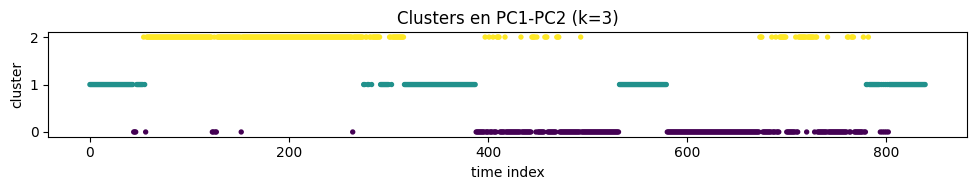

In [20]:
# 11) Clustering K-Means optimizado

X_pcs_2d = scores[:, :2]
kmeans_2d = KMeans(n_clusters=3, random_state=0).fit(X_pcs_2d)
labels_2d = kmeans_2d.labels_

# Guardar serie temporal simple de clusters 
plt.figure(figsize=(10,2))
plt.scatter(np.arange(len(labels_2d)), labels_2d, c=labels_2d, s=8)
plt.xlabel('time index'); plt.ylabel('cluster'); plt.title('Clusters en PC1-PC2 (k=3)')
plt.tight_layout(); plt.savefig(os.path.join(output_dir, "clusters_timeseries_2d.png")); plt.show()


In [21]:

# Análisis
N_CLUSTERS = 3
RANDOM_STATE = 42

# Usamos los scores de PC1, PC2, y PC3 para el análisis real
scores_N = scores[:, :N_CLUSTERS] 

# Modelo K-Means para análisis principal
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE, n_init=10)
kmeans.fit(scores_N)

# Clasificación final para el análisis
cluster_labels = kmeans.labels_

# Guardar centroides (análisis principal)
cluster_centers = pd.DataFrame(
    kmeans.cluster_centers_, 
    columns=[f"PC{i+1}" for i in range(N_CLUSTERS)]
)
cluster_centers.to_csv(os.path.join(output_dir, "kmeans_3_cluster_centers.csv"), 
                      index_label="Cluster_ID")
print(f"Centroides de Clusters K={N_CLUSTERS} guardados.")

# Guardar etiquetas temporales (análisis principal)
df_clusters = pd.DataFrame({
    'valid_time': ds_all.valid_time.values,
    'Cluster_ID': cluster_labels
})
df_clusters.to_csv(os.path.join(output_dir, "friajes_cluster_labels.csv"), index=False)
print(f"Etiquetas de eventos K={N_CLUSTERS} guardadas.")

print("Análisis de clustering completado.")

Centroides de Clusters K=3 guardados.
Etiquetas de eventos K=3 guardadas.
Análisis de clustering completado.


PASO 12

In [22]:
# 12) Cálculo de medias por cluster 

def calculate_cluster_means():
    """Calcula medias por cluster"""
    print("Calculando medias por cluster...")
    
    k = k_clusters
    sums = np.zeros((k, int(total_features)), dtype=np.float64)
    counts = np.zeros(k, dtype=int)

    for i in range(0, ntime, batch_size):
        i2 = min(i + batch_size, ntime)
        block = X_da[i:i2].compute()
        for j in range(block.shape[0]):
            idx = i + j
            cl = int(cluster_labels[idx])
            sums[cl] += block[j].astype(np.float64)
            counts[cl] += 1
        print(f"  Procesado lote {i}:{i2}")

    # Calcular medias
    means = np.zeros_like(sums)
    for cl in range(k):
        if counts[cl] > 0:
            means[cl] = sums[cl] / counts[cl]
        else:
            print(f"Cluster {cl} vacío!")
    
    return means


In [71]:

# CONFIGURACIÓN DE COLORES
COLOR_CONFIG = {
    'z': {'cmap': 'viridis', 'label': 'Geopotencial (m²/s²)'},      #  viridis
    't': {'cmap': 'plasma', 'label': 'Temperatura (K)'},           #  plasma
    'u': {'cmap': 'RdBu_r', 'label': 'Viento Zonal (m/s)'},
    'v': {'cmap': 'RdBu_r', 'label': 'Viento Meridional (m/s)'},
    'r': {'cmap': 'Blues', 'label': 'Humedad Relativa (%)'}        #  Blues
}
k_clusters = N_CLUSTERS

In [24]:

# FUNCIONES AUXILIARES REUTILIZABLES
def get_field_data(mean_vec, var, level):
    """Extrae datos de campo manteniendo lógica original"""
    start = vars_to_use.index(var) * features_per_var
    end = start + features_per_var
    mean_arr = mean_vec[start:end].reshape(nlev, nlat, nlon)
    level_idx = list(ds_sub['pressure_level'].values).index(level)
    return mean_arr[level_idx, :, :]

def setup_map_axis(ax, data, lon, lat, var, vmin, vmax, level, i, plot_type="normal"):
    """Configura eje del mapa manteniendo apariencia original"""
    config = COLOR_CONFIG[var]
    
    # Plot principal
    mesh = ax.contourf(lon, lat, data, levels=15,
                      transform=ccrs.PlateCarree(), 
                      cmap=config['cmap'],
                      vmin=vmin, vmax=vmax,
                      extend='both')
    
    # Elementos del mapa según tipo
    if plot_type == "temperature_best":
        ax.coastlines(linewidth=1.2, color='darkblue')
        ax.add_feature(cfeature.BORDERS, linewidth=0.8, edgecolor='navy')
        ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.3)
        ax.add_feature(cfeature.LAND, color='wheat', alpha=0.2)
        
        # Contornos solo para temperatura
        if var == 't':
            contour_levels = np.linspace(vmin, vmax, 11)
            contours = ax.contour(lon, lat, data, levels=contour_levels,
                                colors='black', linewidths=0.8, alpha=0.8)
            plt.clabel(contours, inline=True, fontsize=7, fmt='%1.1f')
    else:
        ax.coastlines(linewidth=1.0, color='black')
        ax.add_feature(cfeature.BORDERS, linewidth=0.7, edgecolor='gray')
        ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.2)
        ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.1)
    
    # Enfocar en Sudamérica
    ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], 
                 crs=ccrs.PlateCarree())
    
    return mesh


In [25]:

def add_gridlines_and_labels(ax, lon, lat, i):
    """Añade gridlines y etiquetas manteniendo estilo original"""
    lat_ticks = np.linspace(lat.min(), lat.max(), 5)
    lon_ticks = np.linspace(lon.min(), lon.max(), 5)
    
    # Líneas de latitud
    for lat_val in lat_ticks:
        ax.plot([lon.min(), lon.max()], [lat_val, lat_val], 
               color='gray', linewidth=0.3, alpha=0.5, linestyle='--',
               transform=ccrs.PlateCarree())
    
    # Líneas de longitud
    for lon_val in lon_ticks:
        ax.plot([lon_val, lon_val], [lat.min(), lat.max()], 
               color='gray', linewidth=0.3, alpha=0.5, linestyle='--',
               transform=ccrs.PlateCarree())
    
    # Etiquetas manuales
    if i == 0:
        for lat_val in lat_ticks:
            ax.text(lon.min() - 2, lat_val, f'{abs(lat_val):.0f}°{"S" if lat_val < 0 else "N"}', 
                   transform=ccrs.PlateCarree(), fontsize=8, 
                   verticalalignment='center', horizontalalignment='right',
                   bbox=dict(boxstyle='round,pad=0.1', facecolor='white', alpha=0.7))
    
    if i == 1:
        for lon_val in lon_ticks:
            ax.text(lon_val, lat.min() - 2, f'{abs(lon_val):.0f}°{"W" if lon_val < 0 else "E"}', 
                   transform=ccrs.PlateCarree(), fontsize=8,
                   verticalalignment='top', horizontalalignment='center',
                   bbox=dict(boxstyle='round,pad=0.1', facecolor='white', alpha=0.7))


In [26]:

# FUNCIONES PRINCIPALES (PANELES INDIVIDUALES)
def plot_cluster_panels_final(means, output_dir):
    """Paneles individuales por cluster y variable"""
    
    for cl in range(k_clusters):
        mean_vec = means[cl]
        
        for var in vars_to_use:
            fig = plt.figure(figsize=(16, 6))
            levels_to_plot = [250.0, 500.0, 1000.0]
            
            # Calcular rango común
            all_data = [get_field_data(mean_vec, var, level) for level in levels_to_plot]
            
            # Determinar rango (lógica original)
            if var in ['u', 'v']:
                max_abs = max(np.nanmax(np.abs(data)) for data in all_data)
                vmin, vmax = -max_abs, max_abs
            elif var == 't':
                data_min = min(np.nanmin(data) for data in all_data)
                data_max = max(np.nanmax(data) for data in all_data)
                range_val = data_max - data_min
                if range_val < 10:
                    center = (data_max + data_min) / 2
                    vmin, vmax = center - 5, center + 5
                else:
                    vmin, vmax = data_min, data_max
            else:
                vmin = min(np.nanmin(data) for data in all_data)
                vmax = max(np.nanmax(data) for data in all_data)
            
            mesh = None
            for i, level in enumerate(levels_to_plot):
                left = 0.05 + i * 0.3
                bottom = 0.15
                width, height = 0.28, 0.7
                
                ax = fig.add_axes([left, bottom, width, height], projection=ccrs.PlateCarree())
                mesh = setup_map_axis(ax, all_data[i], lon, lat, var, vmin, vmax, level, i)
                add_gridlines_and_labels(ax, lon, lat, i)
                ax.set_title(f'{var.upper()} - {int(level)} hPa', fontsize=11, fontweight='bold', pad=10)
            
            fig.suptitle(f'Cluster {cl} - {var.upper()} - Patrón Promedio', 
                        fontsize=14, fontweight='bold', y=0.92)
            
            cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.03])
            cbar = fig.colorbar(mesh, cax=cbar_ax, orientation='horizontal')
            cbar.set_label(COLOR_CONFIG[var]['label'], fontsize=11, fontweight='bold')
            cbar.ax.tick_params(labelsize=9)
            
            plt.savefig(os.path.join(output_dir, f"cluster{cl}_{var}_final.png"), 
                       dpi=300, bbox_inches='tight')
            plt.close()
            
            print(f"Panel cluster {cl} - {var} guardado")


In [29]:

def plot_temperature_best(means, output_dir):
    """Temperatura con máximo contraste"""
    
    for cl in range(k_clusters):
        mean_vec = means[cl]
        temp_arr = get_field_data(mean_vec, 't', 250.0)  # Solo para obtener la estructura
        start = vars_to_use.index('t') * features_per_var
        end = start + features_per_var
        temp_arr_full = mean_vec[start:end].reshape(nlev, nlat, nlon)
        
        fig = plt.figure(figsize=(16, 6))
        levels_to_plot = [250.0, 500.0, 1000.0]
        
        # Calcular rango con máximo contraste
        all_temp_data = []
        for level in levels_to_plot:
            level_idx = list(ds_sub['pressure_level'].values).index(level)
            all_temp_data.append(temp_arr_full[level_idx, :, :])
        
        all_values = np.concatenate([data.flatten() for data in all_temp_data])
        all_values = all_values[~np.isnan(all_values)]
        p1, p99 = np.percentile(all_values, [1, 99])
        vmin, vmax = p1, p99
        if (vmax - vmin) < 6:
            center = np.median(all_values)
            vmin, vmax = center - 3, center + 3
        
        for i, level in enumerate(levels_to_plot):
            left = 0.05 + i * 0.3
            bottom = 0.15
            width, height = 0.28, 0.7
            
            ax = fig.add_axes([left, bottom, width, height], projection=ccrs.PlateCarree())
            mesh = setup_map_axis(ax, all_temp_data[i], lon, lat, 't', vmin, vmax, level, i, "temperature_best")
            add_gridlines_and_labels(ax, lon, lat, i)
            ax.set_title(f'Temperatura - {int(level)} hPa', fontsize=11, fontweight='bold', pad=10)
        
        fig.suptitle(f'Cluster {cl} - TEMPERATURA - Patrón Sinóptico en Sudamérica', 
                    fontsize=16, fontweight='bold', y=0.92)
        
        cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.03])
        cbar = fig.colorbar(mesh, cax=cbar_ax, orientation='horizontal')
        cbar.set_label('Temperatura (K) -  Cálido |  Medio | Frío', 
                      fontsize=12, fontweight='bold')
        cbar.ax.tick_params(labelsize=10)
        
        plt.savefig(os.path.join(output_dir, f"cluster{cl}_temperature_best.png"), 
                   dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"Temperatura cluster {cl} guardada")


In [30]:
def plot_cluster_panels_grid(means, output_dir):
    """Paneles 3x3"""
    
    variables = ['z', 't', 'u', 'v', 'r']
    variable_names = {'z': 'Geopotencial', 't': 'Temperatura', 'u': 'Viento Zonal', 
                     'v': 'Viento Meridional', 'r': 'Humedad Relativa'}
    
    # PALETAS ESPECÍFICAS CORREGIDAS
    cluster_cmaps = {
        'z': 'viridis',      # Geopotencial
        't': 'plasma',       # Temperatura  
        'u': 'RdBu_r',       # Viento U
        'v': 'RdBu_r',       # Viento V
        'r': 'Blues'         # Humedad
    }
    
    target_levels_hpa = [1000, 500, 250]
    level_map = {1000: nlev - 1, 500: 1, 250: 0}
    
    for level_hpa in target_levels_hpa:
        level_idx = level_map[level_hpa]
        
        fig, axes = plt.subplots(k_clusters, len(variables), 
                                figsize=(20, 12),
                                subplot_kw={'projection': ccrs.PlateCarree()})
        
        if k_clusters == 1:
            axes = axes.reshape(1, -1)
        
        fig.suptitle(f'Patrones de Clusters - {level_hpa} hPa', fontsize=16, y=0.95)
        
        # Almacenar los mesh de cada variable para las colorbars
        variable_meshes = {}
        
        for cluster_idx in range(k_clusters):
            for var_idx, var in enumerate(variables):
                ax = axes[cluster_idx, var_idx]
                field_data = get_field_data(means[cluster_idx], var, level_hpa)
                
                # Usar paletas corregidas
                cmap = cluster_cmaps[var]
                vmin, vmax = np.nanmin(field_data), np.nanmax(field_data)
                
                if var in ['u', 'v']:
                    max_abs = max(abs(vmin), abs(vmax))
                    vmin, vmax = -max_abs, max_abs
                
                mesh = ax.contourf(lon, lat, field_data, levels=15,
                                 transform=ccrs.PlateCarree(),
                                 cmap=cmap, vmin=vmin, vmax=vmax,
                                 extend='both')
                
                # Guardar el mesh de la primera fila para cada variable
                if cluster_idx == 0:
                    variable_meshes[var] = mesh
                
                ax.coastlines(linewidth=0.8)
                ax.add_feature(cfeature.BORDERS, linewidth=0.3, alpha=0.7)
                
                # Contornos para geopotencial
                if var == 'z':
                    contours = ax.contour(lon, lat, field_data, levels=10,
                                        colors='black', linewidths=0.5,
                                        transform=ccrs.PlateCarree())
                    ax.clabel(contours, inline=True, fontsize=6, fmt='%1.0f')
                
                gl = ax.gridlines(draw_labels=True, linewidth=0.5, 
                                color='gray', alpha=0.5, linestyle='--')
                gl.top_labels = gl.right_labels = False
                
                if cluster_idx == 0:
                    ax.set_title(variable_names[var], fontsize=12, pad=10)
                if var_idx == 0:
                    ax.text(-0.15, 0.5, f'Cluster {cluster_idx}', 
                           transform=ax.transAxes, fontsize=12,
                           va='center', ha='center', rotation=90)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.92, wspace=0.1, hspace=0.1)
        
        # COLORBARS CORREGIDAS - UNA POR CADA VARIABLE CON SUS VALORES CORRECTOS
        for var_idx, var in enumerate(variables):
            if var in variable_meshes:
                cax = fig.add_axes([0.02 + var_idx * 0.19, 0.06, 0.015, 0.3])
                cbar = plt.colorbar(variable_meshes[var], cax=cax, orientation='vertical')
                cbar.set_label(variable_names[var], fontsize=9)
                cbar.ax.tick_params(labelsize=8)
        
        plt.savefig(os.path.join(output_dir, f'cluster_panel_{level_hpa}hPa.png'), 
                   dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"Panel 3x3 para {level_hpa} hPa guardado")

In [31]:

def plot_cluster_panels_by_variable(means, output_dir):
    """Paneles 3x1"""
    
    variables = ['z', 't', 'u', 'v', 'r']
    variable_names = {'z': 'Geopotencial', 't': 'Temperatura', 'u': 'Viento Zonal', 
                     'v': 'Viento Meridional', 'r': 'Humedad Relativa'}
    
    # PALETAS ESPECÍFICAS CORREGIDAS para paneles 3x1
    cluster_cmaps = {
        'z': 'viridis',      # Geopotencial 
        't': 'plasma',       # Temperatura   
        'u': 'RdBu_r',       # Viento U
        'v': 'RdBu_r',       # Viento V
        'r': 'Blues'         # Humedad -
    }
    
    target_levels_hpa = [1000, 500, 250]
    level_map = {1000: nlev - 1, 500: 1, 250: 0}
    
    for level_hpa in target_levels_hpa:
        level_idx = level_map[level_hpa]
        
        for var in variables:
            fig, axes = plt.subplots(1, k_clusters, 
                                    figsize=(15, 5),
                                    subplot_kw={'projection': ccrs.PlateCarree()})
            
            if k_clusters == 1:
                axes = [axes]
            
            # Preparar datos para colorbar común
            all_fields = []
            for cluster_idx in range(k_clusters):
                field_data = get_field_data(means[cluster_idx], var, level_hpa)
                all_fields.append(field_data)
            
            all_data = np.concatenate([f.flatten() for f in all_fields])
            vmin, vmax = np.nanmin(all_data), np.nanmax(all_data)
            
            if var in ['u', 'v']:
                max_abs = max(abs(vmin), abs(vmax))
                vmin, vmax = -max_abs, max_abs
            
            cmap = cluster_cmaps[var]
            
            for cluster_idx in range(k_clusters):
                ax = axes[cluster_idx]
                field_data = all_fields[cluster_idx]
                
                mesh = ax.contourf(lon, lat, field_data, levels=15,
                                 transform=ccrs.PlateCarree(),
                                 cmap=cmap, vmin=vmin, vmax=vmax,
                                 extend='both')
                
                ax.coastlines(linewidth=0.8)
                ax.add_feature(cfeature.BORDERS, linewidth=0.3, alpha=0.7)
                
                if var == 'z':
                    contours = ax.contour(lon, lat, field_data, levels=10,
                                        colors='black', linewidths=0.5,
                                        transform=ccrs.PlateCarree())
                    ax.clabel(contours, inline=True, fontsize=6, fmt='%1.0f')
                
                gl = ax.gridlines(draw_labels=True, linewidth=0.5, 
                                color='gray', alpha=0.5, linestyle='--')
                gl.top_labels = gl.right_labels = False
                
                ax.set_title(f'Cluster {cluster_idx}', fontsize=12, pad=10)
            
            fig.suptitle(f'{variable_names[var]} - {level_hpa} hPa', 
                        fontsize=16, y=0.95)
            
            cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.03])
            cbar = plt.colorbar(mesh, cax=cbar_ax, orientation='horizontal')
            cbar.set_label(variable_names[var], fontsize=12)
            cbar.ax.tick_params(labelsize=10)
            
            plt.tight_layout()
            plt.subplots_adjust(top=0.85, bottom=0.15)
            
            plt.savefig(os.path.join(output_dir, f'cluster_{var}_{level_hpa}hPa.png'), 
                       dpi=300, bbox_inches='tight')
            plt.close()
            
            print(f"Panel 3x1 {variable_names[var]} - {level_hpa} hPa guardado")
            


In [32]:
# EJECUCIÓN COMPLETA
print("=== PASO 12: VERSIÓN COMPLETA OPTIMIZADA ===")

k_clusters = N_CLUSTERS


# 1. Calcular medias
means = calculate_cluster_means()

# 2. Generar TODOS los tipos de paneles
print("Generando paneles individuales...")
plot_cluster_panels_final(means, output_dir)

print("Generando temperatura con contraste...")
plot_temperature_best(means, output_dir)

print("Generando paneles 3x3...")
plot_cluster_panels_grid(means, output_dir)

print("Generando paneles 3x1...")
plot_cluster_panels_by_variable(means, output_dir)

print("¡TODOS los paneles de clusters generados exitosamente!")

=== PASO 12: VERSIÓN COMPLETA OPTIMIZADA ===
Calculando medias por cluster...
  Procesado lote 0:20
  Procesado lote 20:40
  Procesado lote 40:60
  Procesado lote 60:80
  Procesado lote 80:100
  Procesado lote 100:120
  Procesado lote 120:140
  Procesado lote 140:160
  Procesado lote 160:180
  Procesado lote 180:200
  Procesado lote 200:220
  Procesado lote 220:240
  Procesado lote 240:260
  Procesado lote 260:280
  Procesado lote 280:300
  Procesado lote 300:320
  Procesado lote 320:340
  Procesado lote 340:360
  Procesado lote 360:380
  Procesado lote 380:400
  Procesado lote 400:420
  Procesado lote 420:440
  Procesado lote 440:460
  Procesado lote 460:480
  Procesado lote 480:500
  Procesado lote 500:520
  Procesado lote 520:540
  Procesado lote 540:560
  Procesado lote 560:580
  Procesado lote 580:600
  Procesado lote 600:620
  Procesado lote 620:640
  Procesado lote 640:660
  Procesado lote 660:680
  Procesado lote 680:700
  Procesado lote 700:720
  Procesado lote 720:740
  Proce

C:\Users\PC\AppData\Local\Temp\ipykernel_23288\22350437.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel 3x1 Geopotencial - 1000 hPa guardado


C:\Users\PC\AppData\Local\Temp\ipykernel_23288\22350437.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel 3x1 Temperatura - 1000 hPa guardado


C:\Users\PC\AppData\Local\Temp\ipykernel_23288\22350437.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel 3x1 Viento Zonal - 1000 hPa guardado


C:\Users\PC\AppData\Local\Temp\ipykernel_23288\22350437.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel 3x1 Viento Meridional - 1000 hPa guardado


C:\Users\PC\AppData\Local\Temp\ipykernel_23288\22350437.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel 3x1 Humedad Relativa - 1000 hPa guardado


C:\Users\PC\AppData\Local\Temp\ipykernel_23288\22350437.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel 3x1 Geopotencial - 500 hPa guardado


C:\Users\PC\AppData\Local\Temp\ipykernel_23288\22350437.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel 3x1 Temperatura - 500 hPa guardado


C:\Users\PC\AppData\Local\Temp\ipykernel_23288\22350437.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel 3x1 Viento Zonal - 500 hPa guardado


C:\Users\PC\AppData\Local\Temp\ipykernel_23288\22350437.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel 3x1 Viento Meridional - 500 hPa guardado


C:\Users\PC\AppData\Local\Temp\ipykernel_23288\22350437.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel 3x1 Humedad Relativa - 500 hPa guardado


C:\Users\PC\AppData\Local\Temp\ipykernel_23288\22350437.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel 3x1 Geopotencial - 250 hPa guardado


C:\Users\PC\AppData\Local\Temp\ipykernel_23288\22350437.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel 3x1 Temperatura - 250 hPa guardado


C:\Users\PC\AppData\Local\Temp\ipykernel_23288\22350437.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel 3x1 Viento Zonal - 250 hPa guardado


C:\Users\PC\AppData\Local\Temp\ipykernel_23288\22350437.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel 3x1 Viento Meridional - 250 hPa guardado


C:\Users\PC\AppData\Local\Temp\ipykernel_23288\22350437.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel 3x1 Humedad Relativa - 250 hPa guardado
¡TODOS los paneles de clusters generados exitosamente!


KMEANS

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import os

N_PCS_PLOT = 2 
k_clusters = 3
output_dir = 'pca_output' 

# Prepare data (scores for PC1 and PC2)
X_pcs_2d = scores[:, :N_PCS_PLOT] 
# labels = labels (Ya definido)

# Plotting 
plt.figure(figsize=(10, 8))

# Scatter plot: PC1 vs PC2, coloreado por cluster label
# Se usa 'c=labels' para diferenciar los 3 grupos.
scatter = plt.scatter(
    X_pcs_2d[:, 0], 
    X_pcs_2d[:, 1], 
    c=labels, 
    cmap='viridis', # Colores claros para los 3 clusters
    s=50,
    alpha=0.7,
    edgecolors='w' 
)

plt.xlabel(f'Score del Componente Principal 1 (10.7% de la varianza)')
plt.ylabel(f'Score del Componente Principal 2 (7.9% de la varianza)')
plt.title(f'Distribución de Eventos en el Espacio PC1-PC2 (K={k_clusters})')
plt.grid(True, linestyle='--', alpha=0.6)

# Leyenda
legend1 = plt.legend(*scatter.legend_elements(), 
                     title="Clúster ID", loc="upper right")
plt.gca().add_artist(legend1)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "pc_scores_plot_colored.png"))
#plt.close()
plt.show()


NameError: name 'labels' is not defined

<Figure size 1000x800 with 0 Axes>

K=3

PARA UNA SOLA FECHA

Dimensiones: ('valid_time', 'pressure_level', 'latitude', 'longitude')
12 281 241


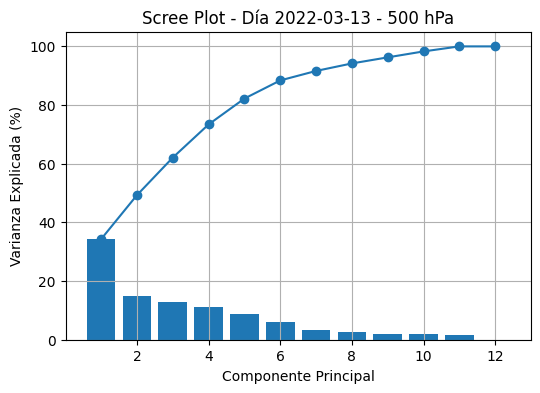

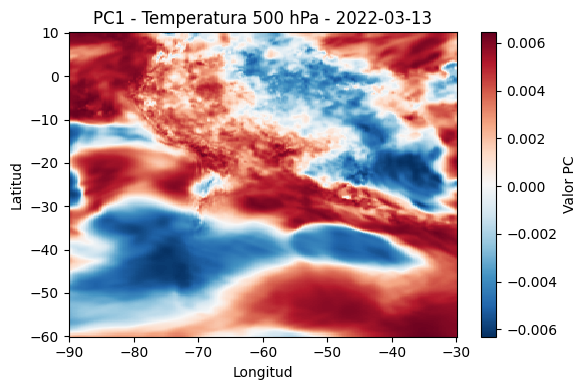

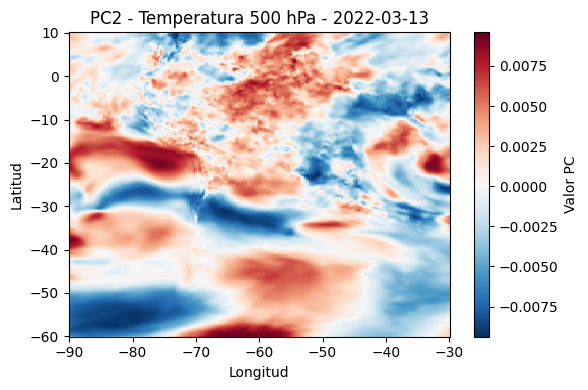

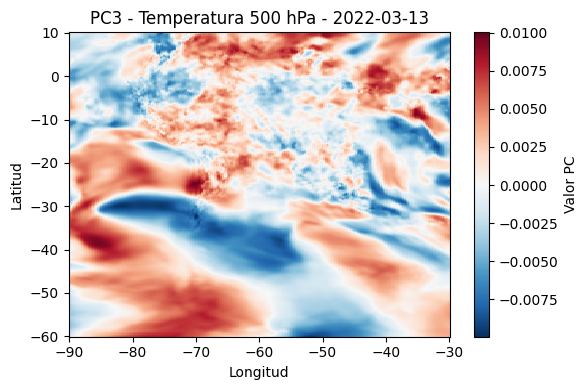

In [34]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

file = r"C:\Users\PC\Documents\JUPYTER\TRABAJO_FINAL_BERTHA\ERA5_500hPa\ERA5_500hPa_2022\ERA5_500hPa_2022-03-13.nc"

ds = xr.open_dataset(file)

# Las coordenadas (para graficar)
lat = ds['latitude'].values
lon = ds['longitude'].values

t = ds['t']         # temperatura en K
print("Dimensiones:", t.dims)  

t2 = t.squeeze()    # (time, lat, lon)

ntime, nlat, nlon = t2.shape
print(ntime, nlat, nlon)

# reshape -> (tiempo, pixeles)
X = t2.values.reshape(ntime, nlat*nlon)

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

pca = PCA()
PCs = pca.fit_transform(X_std)

expl = pca.explained_variance_ratio_
cumvar = np.cumsum(expl)

# Scree plot

plt.figure(figsize=(6,4))
plt.bar(np.arange(1, len(expl)+1), expl*100)
plt.plot(np.arange(1, len(expl)+1), cumvar*100, marker='o')
plt.xlabel("Componente Principal")
plt.ylabel("Varianza Explicada (%)")
plt.title("Scree Plot - Día 2022-03-13 - 500 hPa")
plt.grid(True)
plt.show()

components = pca.components_    

def pc_to_field(pc_vec):
    """Convierte un vector PCA a campo lat×lon"""
    return pc_vec.reshape(nlat, nlon)

PC1 = pc_to_field(components[0])
PC2 = pc_to_field(components[1])
PC3 = pc_to_field(components[2])


def plot_pc(field, title):
    plt.figure(figsize=(6,4))
    plt.pcolormesh(lon, lat, field, cmap="RdBu_r")
    plt.colorbar(label='Valor PC')
    plt.title(title)
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.tight_layout()
    plt.show()

plot_pc(PC1, "PC1 - Temperatura 500 hPa - 2022-03-13")
plot_pc(PC2, "PC2 - Temperatura 500 hPa - 2022-03-13")
plot_pc(PC3, "PC3 - Temperatura 500 hPa - 2022-03-13")


El tercer componente principal (PC3) muestra un patrón dominado por un dipolo latitudinal, con cargas positivas sobre la Amazonía y norte de Sudamérica, y cargas negativas en el dominio extratropical al sur de 30°S. Esto sugiere que el PC3 representa la interacción entre el calentamiento tropical y la dinámica baroclínica en el Pacífico Sur, posiblemente asociada a una onda de Rossby o una vaguada extratropical. El patrón es espacialmente coherente y físicamente consistente, indicando que el PCA capturó una estructura atmosférica real.

El número óptimo de PCs según el método del codo es: 3


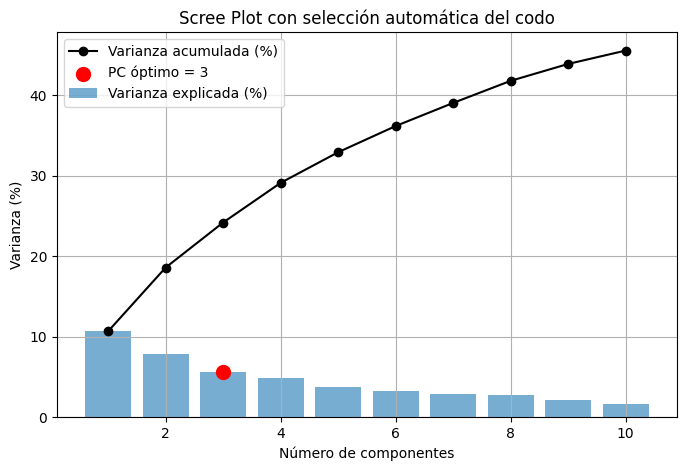

In [35]:
import numpy as np
import matplotlib.pyplot as plt

var_exp = ipca.explained_variance_ratio_

# Puntos de la curva
x = np.arange(1, len(var_exp) + 1)

x1, y1 = x[0], var_exp[0]
x2, y2 = x[-1], var_exp[-1]

# Calcular distancia de cada punto a esa línea
dist = np.abs((y2 - y1)*x - (x2 - x1)*var_exp + x2*y1 - y2*x1) / np.sqrt((y2 - y1)**2 + (x2 - x1)**2)

# Índice del máximo (PC del codo)
pc_optimo = dist.argmax() + 1

print(f"El número óptimo de PCs según el método del codo es: {pc_optimo}")

# Graficar el scree plot con el punto elegido
plt.figure(figsize=(8,5))
plt.bar(x, var_exp * 100, alpha=0.6, label="Varianza explicada (%)")
plt.plot(x, np.cumsum(var_exp) * 100, marker='o', color='black', label="Varianza acumulada (%)")
plt.scatter(pc_optimo, var_exp[pc_optimo-1] * 100, color='red', s=100, label=f"PC óptimo = {pc_optimo}")
plt.xlabel("Número de componentes")
plt.ylabel("Varianza (%)")
plt.title("Scree Plot con selección automática del codo")
plt.grid(True)
plt.legend()
plt.show()


In [36]:
print("Varianza explicada acumulada:")
for i, v in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {v*100:.2f}%")


Varianza explicada acumulada:
PC1: 34.29%
PC2: 15.00%
PC3: 12.80%
PC4: 11.31%
PC5: 8.82%
PC6: 6.18%
PC7: 3.23%
PC8: 2.56%
PC9: 2.07%
PC10: 2.02%
PC11: 1.71%
PC12: 0.00%


In [56]:
def plot_pc(field, title, lat, lon):
    plt.figure(figsize=(6,4))
    plt.pcolormesh(lon, lat, field, cmap="RdBu_r", shading="auto")
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.tight_layout()
    plt.show()


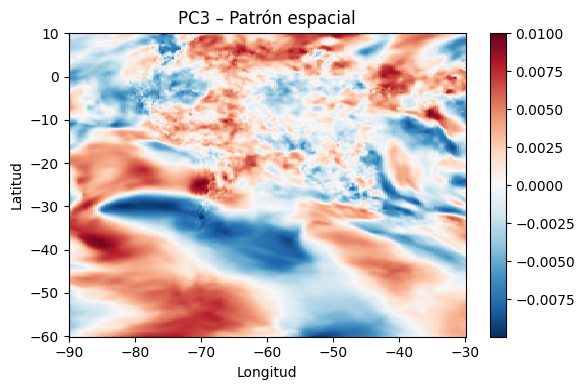

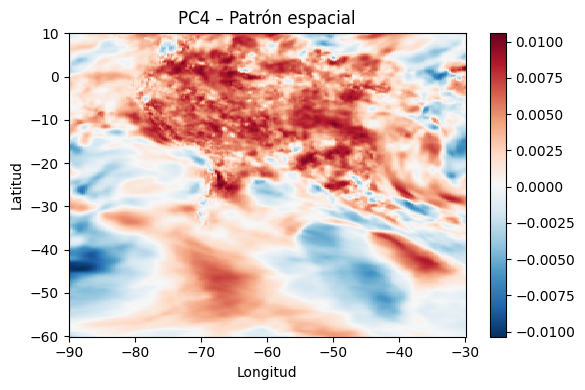

In [57]:
# PC3 → componente número 2 (índice 2)
pc3_map = pca.components_[2].reshape(nlat, nlon)

# PC4 → componente número 3 (índice 3)
pc4_map = pca.components_[3].reshape(nlat, nlon)

plot_pc(pc3_map, "PC3 – Patrón espacial", lat, lon)
plot_pc(pc4_map, "PC4 – Patrón espacial", lat, lon)


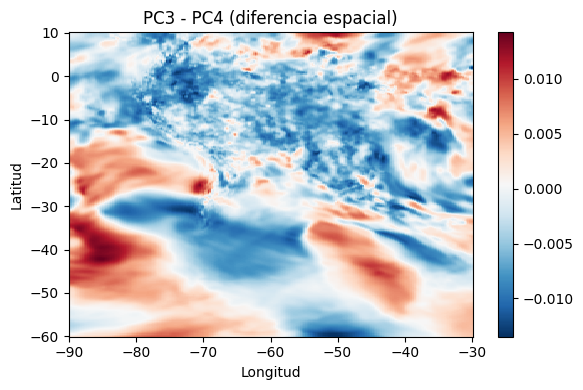

In [58]:
diff = pc3_map - pc4_map
plot_pc(diff, "PC3 - PC4 (diferencia espacial)", lat, lon)


In [59]:
from scipy.stats import pearsonr

corr, _ = pearsonr(pc3_map.flatten(), pc4_map.flatten())
print("Correlación espacial PC3–PC4:", corr)


Correlación espacial PC3–PC4: -0.045836244


Aunque el PC3 explica ligeramente más varianza, el PC4 presenta un patrón espacial de escala sinóptica clara, en este caso PC4 demuestra que es una variable diferente 

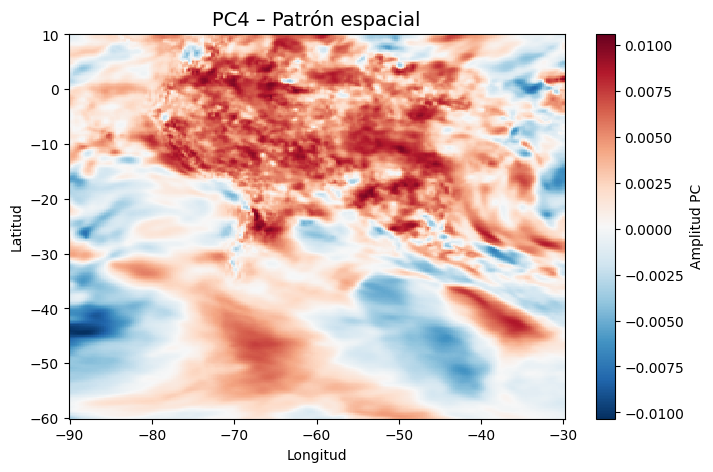

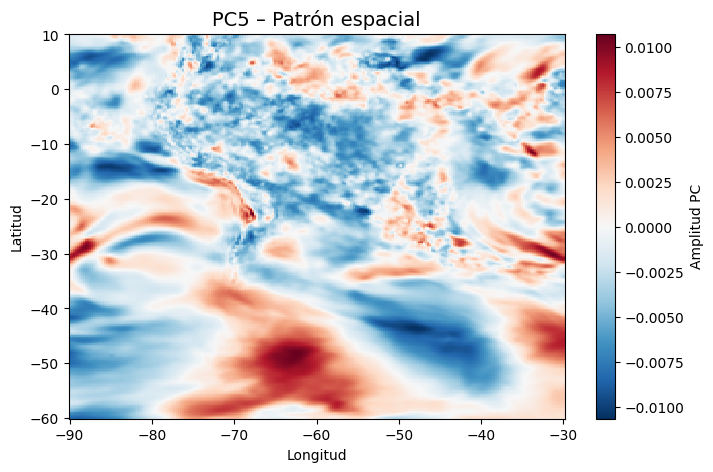

Correlación espacial PC4 – PC5: 0.145888152142143


In [37]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pc_map(component_map, title, lat, lon):
    plt.figure(figsize=(8,5))
    plt.pcolormesh(lon, lat, component_map, shading='auto', cmap='RdBu_r')
    plt.title(title, fontsize=14)
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.colorbar(label="Amplitud PC")
    plt.show()

##(recordar que PC1 es índice 0)
pc4_map = pca.components_[3].reshape(nlat, nlon)

pc5_map = pca.components_[4].reshape(nlat, nlon)

plot_pc_map(pc4_map, "PC4 – Patrón espacial", lat, lon)
plot_pc_map(pc5_map, "PC5 – Patrón espacial", lat, lon)

corr = np.corrcoef(pc4_map.flatten(), pc5_map.flatten())[0,1]
print("Correlación espacial PC4 – PC5:", corr)


Para un análisis sinóptico real, PCA y K-means deben aplicarse usando todas las fechas disponibles, en este caso notamos que usar PC5 es innecesario, debido a la baja correlacion con PC4

# RANDOM FOREST

In [101]:
# CELDA 1 - imports y configuración
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import joblib
import os

# Opcional: si usas cartopy para mapas más bonitos, descomenta
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature

plt.rcParams['figure.figsize'] = (10,6)
RANDOM_STATE = 42
os.makedirs("rf_outputs", exist_ok=True)


In [100]:
print("Variables:", list(ds.data_vars))
print("Coordenadas:", ds.coords)

for v in ds.data_vars:
    print(v, ds[v].shape)


Variables: ['t', 'z', 'u', 'v', 'r']
Coordenadas: Coordinates:
    number          int64 8B ...
  * valid_time      (valid_time) datetime64[ns] 96B 2022-03-12 ... 2022-03-14...
  * pressure_level  (pressure_level) float64 8B 500.0
  * latitude        (latitude) float64 2kB 10.0 9.75 9.5 ... -59.5 -59.75 -60.0
  * longitude       (longitude) float64 2kB -90.0 -89.75 -89.5 ... -30.25 -30.0
    expver          (valid_time) <U4 192B ...
t (12, 1, 281, 241)
z (12, 1, 281, 241)
u (12, 1, 281, 241)
v (12, 1, 281, 241)
r (12, 1, 281, 241)


In [99]:
# Elegir índice de tiempo (0–11)
idx = 0  

ds_sel = ds.isel(valid_time=idx)
print(ds_sel)


<xarray.Dataset> Size: 1MB
Dimensions:         (pressure_level: 1, latitude: 281, longitude: 241)
Coordinates:
    number          int64 8B ...
    valid_time      datetime64[ns] 8B 2022-03-12
  * pressure_level  (pressure_level) float64 8B 500.0
  * latitude        (latitude) float64 2kB 10.0 9.75 9.5 ... -59.5 -59.75 -60.0
  * longitude       (longitude) float64 2kB -90.0 -89.75 -89.5 ... -30.25 -30.0
    expver          <U4 16B ...
Data variables:
    t               (pressure_level, latitude, longitude) float32 271kB ...
    z               (pressure_level, latitude, longitude) float32 271kB ...
    u               (pressure_level, latitude, longitude) float32 271kB ...
    v               (pressure_level, latitude, longitude) float32 271kB ...
    r               (pressure_level, latitude, longitude) float32 271kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conv

In [98]:
lat_min, lat_max = -20, 0
lon_min, lon_max = -80, -70

region = ds_sel.sel(latitude=slice(lat_max, lat_min),
                    longitude=slice(lon_min, lon_max))

region


<xarray.Dataset> Size: 67kB
Dimensions:         (pressure_level: 1, latitude: 81, longitude: 41)
Coordinates:
    number          int64 8B ...
    valid_time      datetime64[ns] 8B 2022-03-12
  * pressure_level  (pressure_level) float64 8B 500.0
  * latitude        (latitude) float64 648B 0.0 -0.25 -0.5 ... -19.75 -20.0
  * longitude       (longitude) float64 328B -80.0 -79.75 -79.5 ... -70.25 -70.0
    expver          <U4 16B ...
Data variables:
    t               (pressure_level, latitude, longitude) float32 13kB ...
    z               (pressure_level, latitude, longitude) float32 13kB ...
    u               (pressure_level, latitude, longitude) float32 13kB ...
    v               (pressure_level, latitude, longitude) float32 13kB ...
    r               (pressure_level, latitude, longitude) float32 13kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-11-14T03:22 GRIB to CDM+CF via cfgrib-0.9.1...

In [102]:
# CELDA 2: CARGAR Y PREPARAR DATOS COMPLETOS DEL DÍA
print("="*60)
print("CARGANDO DATOS COMPLETOS - 2022-03-13")
print("="*60)

def load_full_day_data():
    """Carga datos completos para todas las variables y niveles."""
    
    # Cargar archivos para cada nivel
    base_dir = r"C:\Users\PC\Documents\JUPYTER\TRABAJO_FINAL_BERTHA"
    date_str = "2022-03-13"
    
    datasets = {}
    
    for level in [250, 500, 1000]:
        file_path = os.path.join(
            base_dir, 
            f"ERA5_{level}hPa", 
            f"ERA5_{level}hPa_2022", 
            f"ERA5_{level}hPa_{date_str}.nc"
        )
        
        if os.path.exists(file_path):
            print(f"Cargando {level} hPa...")
            ds = xr.open_dataset(file_path)
            datasets[level] = ds
        else:
            print(f"Archivo no encontrado: {file_path}")
            # Crear dataset vacío con misma estructura
            datasets[level] = None
    
    return datasets

# Cargar datos
datasets = load_full_day_data()

# Verificar estructura
print("\nVariables disponibles en 500 hPa:")
if datasets[500] is not None:
    print(list(datasets[500].data_vars))
    
# CELDA 3: EXTRAER Y ORGANIZAR VARIABLES
print("\n" + "="*60)
print("ORGANIZANDO VARIABLES POR NIVEL")
print("="*60)

def extract_variables_by_level(datasets, variables=['z', 't', 'u', 'v', 'r']):
    """Extrae variables organizadas por nivel."""
    
    data_by_level = {}
    
    for level, ds in datasets.items():
        if ds is None:
            print(f"Saltando nivel {level} hPa (dataset no disponible)")
            continue
            
        level_data = {}
        for var in variables:
            if var in ds.data_vars:
                # Extraer datos (eliminar dimensiones de tamaño 1)
                var_data = ds[var].squeeze().values
                level_data[var] = var_data
                
                # Obtener coordenadas (solo una vez)
                if 'lat' not in level_data and 'latitude' in ds.coords:
                    level_data['lat'] = ds['latitude'].values
                if 'lon' not in level_data and 'longitude' in ds.coords:
                    level_data['lon'] = ds['longitude'].values
                    
        if level_data:
            data_by_level[level] = level_data
            print(f"Nivel {level} hPa: {list(level_data.keys())} variables")
    
    return data_by_level

# Extraer datos organizados
data_by_level = extract_variables_by_level(datasets)

# CELDA 4: DEFINIR SUBREGIÓN DE ENTRENAMIENTO
print("\n" + "="*60)
print("DEFINIENDO SUBREGIÓN DE ENTRENAMIENTO")
print("="*60)

def define_subregion(lat, lon, region_type='south_america', fraction=0.3):
    """
    Define una subregión para entrenamiento.
    
    Parameters:
    -----------
    lat, lon : arrays
        Coordenadas completas
    region_type : str
        Tipo de región: 'random', 'center', 'south_america', 'square'
    fraction : float
        Fracción del dominio a incluir (0-1)
    
    Returns:
    --------
    lat_mask, lon_mask : arrays booleanos
        Máscaras para la subregión
    """
    
    # Ejemplo: región de Sudamérica (ajusta según tus coordenadas)
    if region_type == 'south_america':
        # Coordenadas aproximadas de Sudamérica
        lon_min, lon_max = -85, -30
        lat_min, lat_max = -60, 15
        
        lon_mask = (lon >= lon_min) & (lon <= lon_max)
        lat_mask = (lat >= lat_min) & (lat <= lat_max)
        
    elif region_type == 'center':
        # Región central (30% central del dominio)
        lat_center = (lat.max() + lat.min()) / 2
        lon_center = (lon.max() + lon.min()) / 2
        
        lat_range = (lat.max() - lat.min()) * fraction
        lon_range = (lon.max() - lon.min()) * fraction
        
        lon_mask = (lon >= lon_center - lon_range/2) & (lon <= lon_center + lon_range/2)
        lat_mask = (lat >= lat_center - lat_range/2) & (lat <= lat_center + lat_range/2)
        
    elif region_type == 'random':
        # Selección aleatoria de píxeles
        np.random.seed(RANDOM_STATE)
        total_pixels = len(lat) * len(lon)
        n_selected = int(total_pixels * fraction)
        
        # Crear máscara aleatoria
        flat_mask = np.zeros(total_pixels, dtype=bool)
        flat_mask[:n_selected] = True
        np.random.shuffle(flat_mask)
        
        # Reformar a 2D
        mask_2d = flat_mask.reshape(len(lat), len(lon))
        lat_mask = np.any(mask_2d, axis=1)  # Filas con al menos un píxel seleccionado
        lon_mask = np.any(mask_2d, axis=0)  # Columnas con al menos un píxel seleccionado
        
    elif region_type == 'square':
        # Región cuadrada en una esquina
        lat_mask = (lat >= lat.min()) & (lat <= lat.min() + (lat.max()-lat.min())*fraction)
        lon_mask = (lon >= lon.min()) & (lon <= lon.min() + (lon.max()-lon.min())*fraction)
    
    else:
        raise ValueError(f"Tipo de región no reconocido: {region_type}")
    
    print(f"Subregión '{region_type}':")
    print(f"  Latitudes seleccionadas: {np.sum(lat_mask)}/{len(lat)}")
    print(f"  Longitudes seleccionadas: {np.sum(lon_mask)}/{len(lon)}")
    print(f"  Porcentaje del dominio: {np.sum(lat_mask)*np.sum(lon_mask)/(len(lat)*len(lon))*100:.1f}%")
    
    return lat_mask, lon_mask

# Usar el primer nivel disponible para definir coordenadas
first_level = list(data_by_level.keys())[0]
lat = data_by_level[first_level]['lat']
lon = data_by_level[first_level]['lon']

# Definir subregión (elige el tipo que prefieras)
subregion_type = 'south_america'  # Cambia a 'center', 'random', o 'square'
lat_mask, lon_mask = define_subregion(lat, lon, region_type=subregion_type, fraction=0.4)

# CELDA 5: PREPARAR DATOS PARA RANDOM FOREST
print("\n" + "="*60)
print("PREPARANDO DATOS PARA RANDOM FOREST")
print("="*60)

def prepare_rf_data(data_by_level, lat_mask, lon_mask, 
                   target_level=500, target_variable='t'):
    """
    Prepara datos para Random Forest.
    
    Parameters:
    -----------
    data_by_level : dict
        Diccionario con datos por nivel
    lat_mask, lon_mask : arrays bool
        Máscaras para subregión de entrenamiento
    target_level : int
        Nivel objetivo para reconstrucción
    target_variable : str
        Variable objetivo para reconstrucción
    
    Returns:
    --------
    X_train, y_train : arrays
        Datos de entrenamiento
    X_full, y_full : arrays
        Datos completos para predicción
    feature_names : list
        Nombres de las características
    """
    
    print(f"Preparando datos para: {target_variable.upper()} a {target_level} hPa")
    
    # 1. Datos de la subregión (características X)
    X_samples = []
    feature_names = []
    
    # Para cada píxel en la subregión, extraer características
    # Características: valores de todas las variables en todos los niveles
    lat_indices = np.where(lat_mask)[0]
    lon_indices = np.where(lon_mask)[0]
    
    print(f"  Píxeles en subregión: {len(lat_indices)}×{len(lon_indices)} = {len(lat_indices)*len(lon_indices)}")
    
    for lat_idx in lat_indices:
        for lon_idx in lon_indices:
            features = []
            
            # Para cada nivel y variable
            for level, level_data in data_by_level.items():
                for var_name, var_data in level_data.items():
                    if var_name not in ['lat', 'lon']:
                        # Valor en este píxel
                        pixel_value = var_data[lat_idx, lon_idx]
                        features.append(pixel_value)
                        
                        # Nombre de la característica
                        feature_names.append(f"{var_name}_{level}hPa")
            
            X_samples.append(features)
    
    X_train = np.array(X_samples)
    print(f"  Forma de X_train: {X_train.shape}")
    print(f"  Número de características por píxel: {len(feature_names)}")
    
    # 2. Datos objetivo (y) - valor completo de la variable objetivo
    if target_level in data_by_level and target_variable in data_by_level[target_level]:
        target_data = data_by_level[target_level][target_variable]
        
        # y_train: valores en la subregión (para entrenamiento)
        y_train = target_data[lat_mask, :][:, lon_mask].flatten()
        
        # y_full: valores en todo el dominio (para evaluación)
        y_full = target_data.flatten()
        
        # X_full: necesitamos características para TODO el dominio
        print(f"\n  Preparando características para todo el dominio...")
        X_full_samples = []
        
        for lat_idx in range(len(lat)):
            for lon_idx in range(len(lon)):
                features = []
                for level, level_data in data_by_level.items():
                    for var_name, var_data in level_data.items():
                        if var_name not in ['lat', 'lon']:
                            pixel_value = var_data[lat_idx, lon_idx]
                            features.append(pixel_value)
                
                X_full_samples.append(features)
        
        X_full = np.array(X_full_samples)
        
        print(f"  Forma de y_train: {y_train.shape}")
        print(f"  Forma de X_full: {X_full.shape}")
        print(f"  Forma de y_full: {y_full.shape}")
        
        return X_train, y_train, X_full, y_full, feature_names
    
    else:
        print(f"Error: {target_variable} no encontrado en nivel {target_level}")
        return None, None, None, None, None

# Preparar datos para Random Forest
# Puedes cambiar target_variable y target_level según lo que quieras reconstruir
X_train, y_train, X_full, y_full, feature_names = prepare_rf_data(
    data_by_level, lat_mask, lon_mask,
    target_level=500,  # Nivel a reconstruir
    target_variable='t'  # Variable a reconstruir
)

# CELDA 6: ENTRENAR RANDOM FOREST
print("\n" + "="*60)
print("ENTRENANDO RANDOM FOREST")
print("="*60)

if X_train is not None:
    # Dividir datos de entrenamiento en train/validation
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=RANDOM_STATE
    )
    
    print(f"Datos de entrenamiento: {X_train_split.shape}")
    print(f"Datos de validación: {X_val.shape}")
    
    # Crear y entrenar Random Forest
    print("\nEntrenando Random Forest Regressor...")
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        bootstrap=True,
        random_state=RANDOM_STATE,
        n_jobs=-1,  # Usar todos los núcleos disponibles
        verbose=1
    )
    
    rf_model.fit(X_train_split, y_train_split)
    
    # Evaluar en validación
    y_val_pred = rf_model.predict(X_val)
    
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
    
    mse_val = mean_squared_error(y_val, y_val_pred)
    rmse_val = np.sqrt(mse_val)
    mae_val = mean_absolute_error(y_val, y_val_pred)
    r2_val = r2_score(y_val, y_val_pred)
    
    print("\nResultados en validación:")
    print(f"  MSE: {mse_val:.4f}")
    print(f"  RMSE: {rmse_val:.4f}")
    print(f"  MAE: {mae_val:.4f}")
    print(f"  R²: {r2_val:.4f}")
    
    # Guardar modelo
    model_path = os.path.join("rf_outputs", f"rf_model_{subregion_type}.pkl")
    joblib.dump(rf_model, model_path)
    print(f"\nModelo guardado en: {model_path}")
    
    # Importancia de características
    feature_importance = rf_model.feature_importances_
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 características más importantes:")
    print(importance_df.head(10).to_string(index=False))
    
    # Guardar importancia de características
    importance_path = os.path.join("rf_outputs", "feature_importance.csv")
    importance_df.to_csv(importance_path, index=False)
    print(f"Importancia de características guardada en: {importance_path}")
    
    # CELDA 7: RECONSTRUIR DOMINIO COMPLETO
    print("\n" + "="*60)
    print("RECONSTRUYENDO DOMINIO COMPLETO")
    print("="*60)
    
    print("Prediciendo para todo el dominio...")
    # Nota: Esto puede ser computacionalmente costoso si el dominio es muy grande
    # Podemos predecir en lotes para ahorrar memoria
    
    def predict_in_batches(model, X, batch_size=10000):
        """Predice en lotes para ahorrar memoria."""
        n_samples = X.shape[0]
        predictions = []
        
        for i in range(0, n_samples, batch_size):
            batch_end = min(i + batch_size, n_samples)
            batch_pred = model.predict(X[i:batch_end])
            predictions.append(batch_pred)
            
            # Mostrar progreso
            if (i // batch_size) % 5 == 0:
                print(f"  Procesado: {batch_end}/{n_samples} muestras")
        
        return np.concatenate(predictions)
    
    # Predecir para todo el dominio
    y_full_pred = predict_in_batches(rf_model, X_full)
    
    # Reformar a la forma original del grid
    y_pred_grid = y_full_pred.reshape(len(lat), len(lon))
    y_true_grid = y_full.reshape(len(lat), len(lon))
    
    print(f"Forma de predicción reconstruida: {y_pred_grid.shape}")
    
    # Calcular métricas globales
    mse_full = mean_squared_error(y_full, y_full_pred)
    rmse_full = np.sqrt(mse_full)
    mae_full = mean_absolute_error(y_full, y_full_pred)
    r2_full = r2_score(y_full, y_full_pred)
    
    print("\nResultados en dominio completo:")
    print(f"  MSE: {mse_full:.4f}")
    print(f"  RMSE: {rmse_full:.4f} K")
    print(f"  MAE: {mae_full:.4f} K")
    print(f"  R²: {r2_full:.4f}")
    
    # CELDA 8: VISUALIZAR RESULTADOS
    print("\n" + "="*60)
    print("VISUALIZANDO RESULTADOS")
    print("="*60)
    
    def plot_reconstruction_comparison(true_grid, pred_grid, lat, lon, 
                                     title_base="Temperatura 500 hPa - 2022-03-13"):
        """Compara datos originales vs reconstruidos."""
        
        # Determinar rangos para escalas consistentes
        vmin = min(np.nanmin(true_grid), np.nanmin(pred_grid))
        vmax = max(np.nanmax(true_grid), np.nanmax(pred_grid))
        
        # Crear figura con 3 subplots
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # 1. Datos originales
        im1 = axes[0].contourf(lon, lat, true_grid, levels=20, 
                              cmap='RdBu_r', vmin=vmin, vmax=vmax)
        axes[0].set_title(f"{title_base}\nOriginal", fontsize=12, fontweight='bold')
        axes[0].set_xlabel("Longitud")
        axes[0].set_ylabel("Latitud")
        axes[0].grid(True, alpha=0.3)
        plt.colorbar(im1, ax=axes[0])
        
        # 2. Reconstrucción Random Forest
        im2 = axes[1].contourf(lon, lat, pred_grid, levels=20, 
                              cmap='RdBu_r', vmin=vmin, vmax=vmax)
        axes[1].set_title(f"{title_base}\nReconstrucción RF (R²={r2_full:.3f})", 
                         fontsize=12, fontweight='bold')
        axes[1].set_xlabel("Longitud")
        axes[1].grid(True, alpha=0.3)
        plt.colorbar(im2, ax=axes[1])
        
        # 3. Diferencia (Error)
        diff_grid = pred_grid - true_grid
        max_diff = np.nanmax(np.abs(diff_grid))
        
        im3 = axes[2].contourf(lon, lat, diff_grid, levels=20, 
                              cmap='RdBu_r', vmin=-max_diff, vmax=max_diff)
        axes[2].set_title(f"{title_base}\nError (RMSE={rmse_full:.2f} K)", 
                         fontsize=12, fontweight='bold')
        axes[2].set_xlabel("Longitud")
        axes[2].grid(True, alpha=0.3)
        
        cbar3 = plt.colorbar(im3, ax=axes[2])
        cbar3.set_label('Diferencia (K)')
        
        # Resaltar subregión de entrenamiento
        for ax in axes:
            # Dibujar rectángulo alrededor de la subregión
            lat_min_idx, lat_max_idx = np.where(lat_mask)[0][0], np.where(lat_mask)[0][-1]
            lon_min_idx, lon_max_idx = np.where(lon_mask)[0][0], np.where(lon_mask)[0][-1]
            
            rect_lon = [lon[lon_min_idx], lon[lon_max_idx], lon[lon_max_idx], lon[lon_min_idx], lon[lon_min_idx]]
            rect_lat = [lat[lat_min_idx], lat[lat_min_idx], lat[lat_max_idx], lat[lat_max_idx], lat[lat_min_idx]]
            
            ax.plot(rect_lon, rect_lat, 'r-', linewidth=2, label='Subregión entrenamiento')
            ax.fill(rect_lon, rect_lat, color='red', alpha=0.1)
        
        axes[0].legend(loc='upper right')
        
        plt.tight_layout()
        
        # Guardar figura
        fig_path = os.path.join("rf_outputs", f"reconstruction_comparison_{subregion_type}.png")
        plt.savefig(fig_path, dpi=300, bbox_inches='tight')
        print(f"Figura guardada en: {fig_path}")
        
        plt.show()
        
        return fig
    
    # Visualizar comparación
    fig = plot_reconstruction_comparison(
        y_true_grid, y_pred_grid, lat, lon,
        title_base=f"Temperatura {target_level} hPa - 2022-03-13"
    )
    
    # CELDA 9: ANÁLISIS DE ERROR ESPACIAL
    print("\n" + "="*60)
    print("ANÁLISIS ESPACIAL DEL ERROR")
    print("="*60)
    
    def analyze_spatial_error(true_grid, pred_grid, lat, lon):
        """Analiza la distribución espacial del error."""
        
        error_grid = pred_grid - true_grid
        abs_error_grid = np.abs(error_grid)
        
        # Calcular estadísticas por latitud
        error_by_lat = np.nanmean(abs_error_grid, axis=1)
        
        # Calcular estadísticas por longitud
        error_by_lon = np.nanmean(abs_error_grid, axis=0)
        
        # Crear figura
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # 1. Mapa de error absoluto
        im1 = axes[0, 0].contourf(lon, lat, abs_error_grid, levels=20, cmap='viridis')
        axes[0, 0].set_title("Error Absoluto (K)", fontsize=11, fontweight='bold')
        axes[0, 0].set_xlabel("Longitud")
        axes[0, 0].set_ylabel("Latitud")
        plt.colorbar(im1, ax=axes[0, 0])
        
        # 2. Error por latitud
        axes[0, 1].plot(error_by_lat, lat, 'b-', linewidth=2)
        axes[0, 1].fill_betweenx(lat, 0, error_by_lat, alpha=0.3, color='blue')
        axes[0, 1].set_title("Error Medio por Latitud", fontsize=11, fontweight='bold')
        axes[0, 1].set_xlabel("Error Absoluto Promedio (K)")
        axes[0, 1].set_ylabel("Latitud")
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Error por longitud
        axes[1, 0].plot(lon, error_by_lon, 'r-', linewidth=2)
        axes[1, 0].fill_between(lon, 0, error_by_lon, alpha=0.3, color='red')
        axes[1, 0].set_title("Error Medio por Longitud", fontsize=11, fontweight='bold')
        axes[1, 0].set_xlabel("Longitud")
        axes[1, 0].set_ylabel("Error Absoluto Promedio (K)")
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. Histograma de errores
        axes[1, 1].hist(error_grid.flatten(), bins=50, edgecolor='black', alpha=0.7)
        axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Error cero')
        axes[1, 1].set_title("Distribución de Errores", fontsize=11, fontweight='bold')
        axes[1, 1].set_xlabel("Error (K)")
        axes[1, 1].set_ylabel("Frecuencia")
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        # Estadísticas en el histograma
        mean_error = np.nanmean(error_grid)
        std_error = np.nanstd(error_grid)
        axes[1, 1].text(0.05, 0.95, 
                       f'Media: {mean_error:.3f} K\nStd: {std_error:.3f} K',
                       transform=axes[1, 1].transAxes,
                       verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        plt.tight_layout()
        
        # Guardar
        fig_path = os.path.join("rf_outputs", f"error_analysis_{subregion_type}.png")
        plt.savefig(fig_path, dpi=300, bbox_inches='tight')
        print(f"Análisis de error guardado en: {fig_path}")
        
        plt.show()
        
        # Guardar datos de error
        error_data = {
            'error_grid': error_grid,
            'abs_error_grid': abs_error_grid,
            'error_by_lat': error_by_lat,
            'error_by_lon': error_by_lon
        }
        
        error_path = os.path.join("rf_outputs", f"error_data_{subregion_type}.npz")
        np.savez(error_path, **error_data)
        print(f"Datos de error guardados en: {error_path}")
        
        return error_data
    
    # Ejecutar análisis de error
    error_data = analyze_spatial_error(y_true_grid, y_pred_grid, lat, lon)
    
    # CELDA 10: GUARDAR RESULTADOS FINALES
    print("\n" + "="*60)
    print("GUARDANDO RESULTADOS FINALES")
    print("="*60)
    
    def save_final_results(true_grid, pred_grid, lat, lon, rf_model, 
                          metrics, feature_names, subregion_type):
        """Guarda todos los resultados en formato netCDF."""
        
        # Crear Dataset xarray
        ds_results = xr.Dataset(
            {
                'temperature_original': (['lat', 'lon'], true_grid),
                'temperature_reconstructed': (['lat', 'lon'], pred_grid),
                'temperature_error': (['lat', 'lon'], pred_grid - true_grid)
            },
            coords={
                'lat': lat,
                'lon': lon
            },
            attrs={
                'description': 'Reconstrucción con Random Forest',
                'date': '2022-03-13',
                'subregion_type': subregion_type,
                'model_type': 'RandomForestRegressor',
                'n_estimators': rf_model.n_estimators,
                'max_depth': rf_model.max_depth,
                'r2_score': float(metrics['r2']),
                'rmse': float(metrics['rmse']),
                'mae': float(metrics['mae']),
                'training_data_percentage': f'{np.sum(lat_mask)*np.sum(lon_mask)/(len(lat)*len(lon))*100:.1f}%'
            }
        )
        
        # Guardar como netCDF
        nc_path = os.path.join("rf_outputs", f"reconstruction_results_{subregion_type}.nc")
        ds_results.to_netcdf(nc_path)
        print(f"Resultados guardados en: {nc_path}")
        
        # Guardar métricas en CSV
        metrics_df = pd.DataFrame([metrics])
        metrics_path = os.path.join("rf_outputs", f"metrics_{subregion_type}.csv")
        metrics_df.to_csv(metrics_path, index=False)
        print(f"Métricas guardadas en: {metrics_path}")
        
        # Crear reporte resumen
        report = f"""
        REPORTE DE RECONSTRUCCIÓN - RANDOM FOREST
        {'='*50}
        
        Fecha analizada: 2022-03-13
        Variable reconstruida: Temperatura a 500 hPa
        Tipo de subregión: {subregion_type}
        
        PARÁMETROS DEL MODELO:
        - Número de árboles: {rf_model.n_estimators}
        - Profundidad máxima: {rf_model.max_depth}
        - Características: {len(feature_names)}
        
        RESULTADOS:
        - R² Score: {metrics['r2']:.4f}
        - RMSE: {metrics['rmse']:.4f} K
        - MAE: {metrics['mae']:.4f} K
        - MSE: {metrics['mse']:.4f}
        
        SUBREGIÓN DE ENTRENAMIENTO:
        - Píxeles de entrenamiento: {X_train.shape[0]}
        - Porcentaje del dominio: {X_train.shape[0]/(len(lat)*len(lon))*100:.1f}%
        - Latitudes cubiertas: {np.sum(lat_mask)}/{len(lat)}
        - Longitudes cubiertas: {np.sum(lon_mask)}/{len(lon)}
        
        CARACTERÍSTICAS MÁS IMPORTANTES:
        {importance_df.head(5).to_string(index=False)}
        """
        
        report_path = os.path.join("rf_outputs", f"summary_report_{subregion_type}.txt")
        with open(report_path, 'w') as f:
            f.write(report)
        
        print(f"Reporte guardado en: {report_path}")
        
        return ds_results
    
    # Métricas finales
    final_metrics = {
        'r2': r2_full,
        'rmse': rmse_full,
        'mae': mae_full,
        'mse': mse_full
    }
    
    # Guardar resultados
    ds_results = save_final_results(
        y_true_grid, y_pred_grid, lat, lon, rf_model,
        final_metrics, feature_names, subregion_type
    )
    
    print("\n" + "="*60)
    print("¡PROCESO COMPLETADO EXITOSAMENTE!")
    print("="*60)
    print(f"\nTodos los resultados están en la carpeta: rf_outputs/")
    print("\nArchivos generados:")
    print("1. Modelo Random Forest (.pkl)")
    print("2. Importancia de características (.csv)")
    print("3. Comparación visual (.png)")
    print("4. Análisis de error (.png, .npz)")
    print("5. Resultados en netCDF (.nc)")
    print("6. Métricas (.csv)")
    print("7. Reporte resumen (.txt)")
    
else:
    print("Error: No se pudieron preparar los datos para Random Forest")

CARGANDO DATOS COMPLETOS - 2022-03-13
Cargando 250 hPa...
Cargando 500 hPa...
Cargando 1000 hPa...

Variables disponibles en 500 hPa:
['t', 'z', 'u', 'v', 'r']

ORGANIZANDO VARIABLES POR NIVEL
Nivel 250 hPa: ['z', 'lat', 'lon', 't', 'u', 'v', 'r'] variables
Nivel 500 hPa: ['z', 'lat', 'lon', 't', 'u', 'v', 'r'] variables
Nivel 1000 hPa: ['z', 'lat', 'lon', 't', 'u', 'v', 'r'] variables

DEFINIENDO SUBREGIÓN DE ENTRENAMIENTO
Subregión 'south_america':
  Latitudes seleccionadas: 281/281
  Longitudes seleccionadas: 221/241
  Porcentaje del dominio: 91.7%

PREPARANDO DATOS PARA RANDOM FOREST
Preparando datos para: T a 500 hPa
  Píxeles en subregión: 281×221 = 62101


IndexError: index 12 is out of bounds for axis 0 with size 12

In [73]:
# ============================================================================
# CÓDIGO COMPLETO DEPURADO - RECONSTRUCCIÓN CON RANDOM FOREST
# ============================================================================

# CELDA 1: IMPORTS Y CONFIGURACIÓN
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (10,6)
RANDOM_STATE = 42
os.makedirs("rf_outputs", exist_ok=True)

print("="*70)
print("INICIO - RECONSTRUCCIÓN CON RANDOM FOREST")
print("="*70)

INICIO - RECONSTRUCCIÓN CON RANDOM FOREST


In [103]:
# CELDA 2: CARGAR Y PREPARAR DATOS COMPLETOS DEL DÍA
print("="*60)
print("CARGANDO DATOS COMPLETOS - 2022-03-13")
print("="*60)

def load_full_day_data():
    """Carga datos completos para todas las variables y niveles."""
    
    # Cargar archivos para cada nivel
    base_dir = r"C:\Users\PC\Documents\JUPYTER\TRABAJO_FINAL_BERTHA"
    date_str = "2022-03-13"
    
    datasets = {}
    
    for level in [250, 500, 1000]:
        file_path = os.path.join(
            base_dir, 
            f"ERA5_{level}hPa", 
            f"ERA5_{level}hPa_2022", 
            f"ERA5_{level}hPa_{date_str}.nc"
        )
        
        if os.path.exists(file_path):
            print(f"Cargando {level} hPa...")
            ds = xr.open_dataset(file_path)
            datasets[level] = ds
        else:
            print(f"Archivo no encontrado: {file_path}")
            # Crear dataset vacío con misma estructura
            datasets[level] = None
    
    return datasets

# Cargar datos
datasets = load_full_day_data()

# Verificar estructura
print("\nVariables disponibles en 500 hPa:")
if datasets[500] is not None:
    print(list(datasets[500].data_vars))
    

CARGANDO DATOS COMPLETOS - 2022-03-13
Cargando 250 hPa...
Cargando 500 hPa...
Cargando 1000 hPa...

Variables disponibles en 500 hPa:
['t', 'z', 'u', 'v', 'r']


In [104]:
## CELDA 3 CORREGIDA: VERIFICAR CONSISTENCIA DE DIMENSIONES
# ----------------------------------------------------------------------------
print("\n2. VERIFICANDO CONSISTENCIA DE DIMENSIONES")
print("-"*40)

# Encontrar el nivel con datos más completos
nivel_referencia = None
for nivel in [500, 250, 1000]:
    if nivel in datos_por_nivel and datos_por_nivel[nivel] is not None:
        nivel_referencia = nivel
        break

if nivel_referencia is None:
    print("✗ ERROR: No se pudo cargar ningún nivel de datos")
    exit()
else:
    print(f"Nivel de referencia: {nivel_referencia} hPa")

# Usar coordenadas del nivel de referencia
datos_ref = datos_por_nivel[nivel_referencia]

# Verificar si las coordenadas están disponibles
if 'lat' in datos_ref and 'lon' in datos_ref:
    lat = datos_ref['lat']
    lon = datos_ref['lon']
    nlat, nlon = len(lat), len(lon)
    
    print(f"Coordenadas del nivel de referencia:")
    print(f"  Latitudes: {nlat} valores, rango: {lat[0]:.1f} a {lat[-1]:.1f}")
    print(f"  Longitudes: {nlon} valores, rango: {lon[0]:.1f} a {lon[-1]:.1f}")
else:
    print("⚠️ ADVERTENCIA: No se encontraron coordenadas en el nivel de referencia")
    print("Usando dimensiones de la primera variable disponible...")
    
    # Buscar cualquier variable para obtener dimensiones
    for var_nombre, var_datos in datos_ref.items():
        if var_nombre not in ['lat', 'lon'] and var_datos is not None:
            # Eliminar dimensiones extra
            var_procesada = np.squeeze(var_datos)
            if var_procesada.ndim == 2:
                nlat, nlon = var_procesada.shape
                print(f"  Dimensiones de {var_nombre}: {nlat}×{nlon}")
                
                # Crear coordenadas dummy
                lat = np.arange(nlat)
                lon = np.arange(nlon)
                break

print(f"\nDimensiones del grid: {nlat}×{nlon}")

# Verificar dimensiones de todas las variables en todos los niveles
for nivel, datos_nivel in datos_por_nivel.items():
    if datos_nivel is not None:
        print(f"\nNivel {nivel} hPa:")
        for var_nombre, var_datos in datos_nivel.items():
            if var_nombre not in ['lat', 'lon'] and var_datos is not None:
                print(f"  {var_nombre}: {var_datos.shape} -> ", end="")
                
                # Mostrar dimensiones después de procesar
                var_procesada = np.squeeze(var_datos)
                print(f"procesada: {var_procesada.shape}")


2. VERIFICANDO CONSISTENCIA DE DIMENSIONES
----------------------------------------
Nivel de referencia: 500 hPa
Coordenadas del nivel de referencia:
  Latitudes: 281 valores, rango: 10.0 a -60.0
  Longitudes: 241 valores, rango: -90.0 a -30.0

Dimensiones del grid: 281×241

Nivel 250 hPa:
  z: (12, 281, 241) -> procesada: (12, 281, 241)
  t: (12, 281, 241) -> procesada: (12, 281, 241)
  u: (12, 281, 241) -> procesada: (12, 281, 241)
  v: (12, 281, 241) -> procesada: (12, 281, 241)
  r: (12, 281, 241) -> procesada: (12, 281, 241)

Nivel 500 hPa:
  z: (12, 281, 241) -> procesada: (12, 281, 241)
  t: (12, 281, 241) -> procesada: (12, 281, 241)
  u: (12, 281, 241) -> procesada: (12, 281, 241)
  v: (12, 281, 241) -> procesada: (12, 281, 241)
  r: (12, 281, 241) -> procesada: (12, 281, 241)

Nivel 1000 hPa:
  z: (12, 281, 241) -> procesada: (12, 281, 241)
  t: (12, 281, 241) -> procesada: (12, 281, 241)
  u: (12, 281, 241) -> procesada: (12, 281, 241)
  v: (12, 281, 241) -> procesada: (12,

In [105]:
# ----------------------------------------------------------------------------
# CELDA 4: DEFINIR SUBREGIÓN DE ENTRENAMIENTO (SIMPLIFICADA)
# ----------------------------------------------------------------------------
print("\n3. DEFINIR SUBREGIÓN DE ENTRENAMIENTO")
print("-"*40)

# Método seguro: usar una región cuadrada central
fraccion = 0.4  # Usar 40% del dominio en cada dirección

# Calcular índices centrales
idx_lat_centro = nlat // 2
idx_lon_centro = nlon // 2

# Calcular tamaño de la subregión
tam_subregion_lat = int(nlat * fraccion)
tam_subregion_lon = int(nlon * fraccion)

# Calcular límites de índices
idx_lat_inicio = max(0, idx_lat_centro - tam_subregion_lat // 2)
idx_lat_fin = min(nlat, idx_lat_centro + tam_subregion_lat // 2)
idx_lon_inicio = max(0, idx_lon_centro - tam_subregion_lon // 2)
idx_lon_fin = min(nlon, idx_lon_centro + tam_subregion_lon // 2)

# Crear máscaras booleanas
lat_mask = np.zeros(nlat, dtype=bool)
lon_mask = np.zeros(nlon, dtype=bool)
lat_mask[idx_lat_inicio:idx_lat_fin] = True
lon_mask[idx_lon_inicio:idx_lon_fin] = True

print(f"Subregión CENTRAL seleccionada:")
print(f"  Latitudes: índices {idx_lat_inicio} a {idx_lat_fin} ({np.sum(lat_mask)}/{nlat})")
print(f"  Longitudes: índices {idx_lon_inicio} a {idx_lon_fin} ({np.sum(lon_mask)}/{nlon})")
print(f"  Píxeles totales en subregión: {np.sum(lat_mask) * np.sum(lon_mask)}")
print(f"  Porcentaje del dominio: {np.sum(lat_mask) * np.sum(lon_mask) / (nlat * nlon) * 100:.1f}%")



3. DEFINIR SUBREGIÓN DE ENTRENAMIENTO
----------------------------------------
Subregión CENTRAL seleccionada:
  Latitudes: índices 84 a 196 (112/281)
  Longitudes: índices 72 a 168 (96/241)
  Píxeles totales en subregión: 10752
  Porcentaje del dominio: 15.9%


In [106]:
# CELDA 5 CORREGIDA: PREPARAR DATOS PARA RANDOM FOREST (VERSIÓN ROBUSTA)
# ----------------------------------------------------------------------------
print("\n4. PREPARAR DATOS PARA RANDOM FOREST")
print("-"*40)

def preparar_datos_rf_robusto(datos_por_nivel, lat_mask, lon_mask, 
                             nivel_objetivo=500, variable_objetivo='t'):
    """
    Prepara datos para RF de manera robusta, manejando dimensiones inconsistentes.
    """
    
    print(f"Variable objetivo: {variable_objetivo.upper()} a {nivel_objetivo} hPa")
    
    # Verificar que el nivel objetivo existe
    if nivel_objetivo not in datos_por_nivel or datos_por_nivel[nivel_objetivo] is None:
        print(f"✗ Error: Nivel {nivel_objetivo} hPa no disponible")
        return None, None, None, None, None
    
    datos_objetivo = datos_por_nivel[nivel_objetivo]
    
    if variable_objetivo not in datos_objetivo or datos_objetivo[variable_objetivo] is None:
        print(f"✗ Error: Variable {variable_objetivo} no disponible en nivel {nivel_objetivo}")
        return None, None, None, None, None
    
    # Obtener datos objetivo y eliminar dimensiones extra
    y_data = datos_objetivo[variable_objetivo]
    
    # Verificar dimensiones
    print(f"  Dimensiones originales de y_data: {y_data.shape}")
    
    # Si tiene más de 2 dimensiones, eliminar dimensiones de tamaño 1
    if y_data.ndim > 2:
        print(f"  Reduciendo dimensiones de {y_data.ndim} a 2...")
        # Eliminar dimensiones de tamaño 1 (como time si es un solo día)
        y_data_squeezed = np.squeeze(y_data)
        print(f"  Dimensiones después de squeeze: {y_data_squeezed.shape}")
        
        # Si todavía tiene más de 2 dimensiones, tomar la primera
        if y_data_squeezed.ndim > 2:
            print(f"  Tomando primer elemento de la primera dimensión...")
            y_data = y_data_squeezed[0]
        else:
            y_data = y_data_squeezed
    
    # Ahora debería tener exactamente 2 dimensiones
    if y_data.ndim != 2:
        print(f"✗ Error: y_data tiene {y_data.ndim} dimensiones, se esperaban 2")
        print(f"  Forma actual: {y_data.shape}")
        return None, None, None, None, None
    
    y_nlat, y_nlon = y_data.shape
    
    print(f"  Dimensiones finales de variable objetivo: {y_nlat}×{y_nlon}")
    
    # Asegurar que las máscaras tengan el tamaño correcto
    if len(lat_mask) != y_nlat or len(lon_mask) != y_nlon:
        print(f"  ⚠️ Ajustando máscaras a dimensiones objetivo...")
        print(f"    lat_mask: {len(lat_mask)} -> {y_nlat}")
        print(f"    lon_mask: {len(lon_mask)} -> {y_nlon}")
        
        # Recortar o extender máscaras para que coincidan
        if len(lat_mask) > y_nlat:
            lat_mask_adj = lat_mask[:y_nlat]
        else:
            lat_mask_adj = np.pad(lat_mask, (0, y_nlat - len(lat_mask)), 'constant', constant_values=False)
        
        if len(lon_mask) > y_nlon:
            lon_mask_adj = lon_mask[:y_nlon]
        else:
            lon_mask_adj = np.pad(lon_mask, (0, y_nlon - len(lon_mask)), 'constant', constant_values=False)
    else:
        lat_mask_adj = lat_mask
        lon_mask_adj = lon_mask
    
    print(f"  Máscaras ajustadas: lat={len(lat_mask_adj)}, lon={len(lon_mask_adj)}")
    
    # 1. Preparar características (X) - SOLO de la subregión
    print("\n  Extrayendo características de la subregión...")
    
    X_muestras = []
    nombres_caracteristicas = []
    
    # Primero, procesar todas las variables para asegurar dimensiones consistentes
    print("  Preparando estructura de variables...")
    
    # Diccionario para almacenar todas las variables procesadas (sin dimensiones extra)
    variables_procesadas = {}
    
    for nivel, datos_nivel in datos_por_nivel.items():
        if datos_nivel is None:
            continue
        
        for var_nombre, var_datos in datos_nivel.items():
            if var_nombre not in ['lat', 'lon'] and var_datos is not None:
                # Procesar cada variable para eliminar dimensiones extra
                var_procesada = var_datos
                
                # Si tiene más de 2 dimensiones, reducirlas
                if var_procesada.ndim > 2:
                    var_procesada = np.squeeze(var_procesada)
                    # Si todavía tiene más de 2 dimensiones, tomar el primer elemento
                    if var_procesada.ndim > 2:
                        var_procesada = var_procesada[0]
                
                # Verificar que tenga 2 dimensiones
                if var_procesada.ndim == 2:
                    variables_procesadas[f"{var_nombre}_{nivel}hPa"] = var_procesada
                else:
                    print(f"    ⚠️ Variable {var_nombre}_{nivel}hPa tiene {var_procesada.ndim} dimensiones, se omite")
    
    print(f"  Variables procesadas: {len(variables_procesadas)}")
    
    # Obtener índices de la subregión
    idx_lat_sub = np.where(lat_mask_adj)[0]
    idx_lon_sub = np.where(lon_mask_adj)[0]
    
    total_pixeles = len(idx_lat_sub) * len(idx_lon_sub)
    print(f"  Total de píxeles en subregión: {total_pixeles}")
    
    # Para cada píxel en la subregión
    contador = 0
    for i_lat in idx_lat_sub:
        for i_lon in idx_lon_sub:
            caracteristicas = []
            
            # Para cada variable procesada
            for var_nombre, var_datos in variables_procesadas.items():
                # Verificar que los índices estén dentro de los límites
                if i_lat < var_datos.shape[0] and i_lon < var_datos.shape[1]:
                    valor = var_datos[i_lat, i_lon]
                    caracteristicas.append(valor)
                else:
                    caracteristicas.append(np.nan)
            
            X_muestras.append(caracteristicas)
            contador += 1
            
            if contador % 500 == 0:
                print(f"    Procesados: {contador}/{total_pixeles} píxeles")
    
    # Los nombres de características son las claves del diccionario
    nombres_caracteristicas = list(variables_procesadas.keys())
    
    X_train = np.array(X_muestras)
    print(f"  ✓ X_train preparado: {X_train.shape}")
    print(f"  ✓ Características por píxel: {X_train.shape[1]}")
    
    # 2. Preparar variable objetivo (y) - SOLO de la subregión
    y_train = y_data[lat_mask_adj, :][:, lon_mask_adj].flatten()
    print(f"  ✓ y_train preparado: {y_train.shape}")
    
    # 3. Preparar características para TODO el dominio
    print("\n  Preparando características para dominio completo...")
    X_completo_muestras = []
    
    total_pixeles_completo = y_nlat * y_nlon
    
    for i_lat in range(y_nlat):
        for i_lon in range(y_nlon):
            caracteristicas = []
            
            for var_nombre, var_datos in variables_procesadas.items():
                if i_lat < var_datos.shape[0] and i_lon < var_datos.shape[1]:
                    valor = var_datos[i_lat, i_lon]
                    caracteristicas.append(valor)
                else:
                    caracteristicas.append(np.nan)
            
            X_completo_muestras.append(caracteristicas)
            
            # Mostrar progreso
            if len(X_completo_muestras) % 10000 == 0:
                print(f"    Procesados: {len(X_completo_muestras)}/{total_pixeles_completo} píxeles")
    
    X_full = np.array(X_completo_muestras)
    y_full = y_data.flatten()
    
    print(f"  ✓ X_full preparado: {X_full.shape}")
    print(f"  ✓ y_full preparado: {y_full.shape}")
    print(f"  ✓ Número total de características: {len(nombres_caracteristicas)}")
    
    # Mostrar algunas características como ejemplo
    print(f"\n  Ejemplo de características (primeras 5):")
    for i, nombre in enumerate(nombres_caracteristicas[:5]):
        print(f"    {i+1}. {nombre}")
    
    return X_train, y_train, X_full, y_full, nombres_caracteristicas

# Preparar datos para Random Forest
X_train, y_train, X_full, y_full, nombres_caracteristicas = preparar_datos_rf_robusto(
    datos_por_nivel, lat_mask, lon_mask,
    nivel_objetivo=500,
    variable_objetivo='t'
)

if X_train is None:
    print("✗ ERROR: No se pudieron preparar los datos para Random Forest")
    exit()

# Verificar las dimensiones
print(f"\n✓ Datos preparados exitosamente:")
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  X_full shape: {X_full.shape}")
print(f"  y_full shape: {y_full.shape}")
print(f"  Número de características: {len(nombres_caracteristicas)}")


4. PREPARAR DATOS PARA RANDOM FOREST
----------------------------------------
Variable objetivo: T a 500 hPa
  Dimensiones originales de y_data: (12, 281, 241)
  Reduciendo dimensiones de 3 a 2...
  Dimensiones después de squeeze: (12, 281, 241)
  Tomando primer elemento de la primera dimensión...
  Dimensiones finales de variable objetivo: 281×241
  Máscaras ajustadas: lat=281, lon=241

  Extrayendo características de la subregión...
  Preparando estructura de variables...
  Variables procesadas: 15
  Total de píxeles en subregión: 10752
    Procesados: 500/10752 píxeles
    Procesados: 1000/10752 píxeles
    Procesados: 1500/10752 píxeles
    Procesados: 2000/10752 píxeles
    Procesados: 2500/10752 píxeles
    Procesados: 3000/10752 píxeles
    Procesados: 3500/10752 píxeles
    Procesados: 4000/10752 píxeles
    Procesados: 4500/10752 píxeles
    Procesados: 5000/10752 píxeles
    Procesados: 5500/10752 píxeles
    Procesados: 6000/10752 píxeles
    Procesados: 6500/10752 píxeles


In [107]:
# ----------------------------------------------------------------------------
# CELDA 6: MANEJO DE VALORES FALTANTES
# ----------------------------------------------------------------------------
print("\n5. MANEJO DE VALORES FALTANTES")
print("-"*40)

# Verificar valores NaN
nan_X_train = np.isnan(X_train).sum()
nan_y_train = np.isnan(y_train).sum()
nan_X_full = np.isnan(X_full).sum()

print(f"NaN en X_train: {nan_X_train} ({nan_X_train/X_train.size*100:.2f}%)")
print(f"NaN en y_train: {nan_y_train} ({nan_y_train/len(y_train)*100:.2f}%)")
print(f"NaN en X_full: {nan_X_full} ({nan_X_full/X_full.size*100:.2f}%)")

# Rellenar NaN en características
if nan_X_train > 0 or nan_X_full > 0:
    print("Rellenando NaN en características con la media...")
    imputador = SimpleImputer(strategy='mean')
    X_train = imputador.fit_transform(X_train)
    X_full = imputador.transform(X_full)
    print("✓ NaN rellenados en características")
else:
    print("✓ No hay NaN en características")

# Rellenar NaN en variable objetivo
if nan_y_train > 0:
    print("Rellenando NaN en variable objetivo...")
    media_y = np.nanmean(y_train)
    y_train = np.nan_to_num(y_train, nan=media_y)
    print(f"✓ NaN rellenados en y_train (usando media: {media_y:.2f})")
else:
    print("✓ No hay NaN en variable objetivo")


5. MANEJO DE VALORES FALTANTES
----------------------------------------
NaN en X_train: 0 (0.00%)
NaN en y_train: 0 (0.00%)
NaN en X_full: 0 (0.00%)
✓ No hay NaN en características
✓ No hay NaN en variable objetivo


In [108]:
# ----------------------------------------------------------------------------
# CELDA 7: ENTRENAR RANDOM FOREST
# ----------------------------------------------------------------------------
print("\n6. ENTRENANDO RANDOM FOREST")
print("-"*40)

# Dividir datos de entrenamiento
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_STATE
)

print(f"Datos de entrenamiento: {X_train_split.shape}")
print(f"Datos de validación: {X_val.shape}")

# Configurar Random Forest
print("\nConfigurando Random Forest Regressor...")
rf_modelo = RandomForestRegressor(
    n_estimators=100,       # Número de árboles
    max_depth=15,           # Profundidad máxima
    min_samples_split=5,    # Mínimo muestras para dividir
    min_samples_leaf=2,     # Mínimo muestras en hoja
    max_features='sqrt',    # Número de características para dividir
    bootstrap=True,         # Muestreo bootstrap
    random_state=RANDOM_STATE,
    n_jobs=-1,              # Usar todos los núcleos
    verbose=1
)

# Entrenar modelo
print("Entrenando modelo...")
rf_modelo.fit(X_train_split, y_train_split)
print("✓ Modelo entrenado exitosamente")

# Evaluar en validación
y_val_pred = rf_modelo.predict(X_val)

mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)

print("\nRESULTADOS EN VALIDACIÓN:")
print(f"  R² Score: {r2_val:.4f}")
print(f"  RMSE: {rmse_val:.4f} K")
print(f"  MAE: {mae_val:.4f} K")
print(f"  MSE: {mse_val:.4f}")


6. ENTRENANDO RANDOM FOREST
----------------------------------------
Datos de entrenamiento: (8601, 15)
Datos de validación: (2151, 15)

Configurando Random Forest Regressor...
Entrenando modelo...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.2s


✓ Modelo entrenado exitosamente

RESULTADOS EN VALIDACIÓN:
  R² Score: 0.9993
  RMSE: 0.0803 K
  MAE: 0.0507 K
  MSE: 0.0065


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  27 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [109]:
# ----------------------------------------------------------------------------
# CELDA 8: IMPORTANCIA DE CARACTERÍSTICAS
# ----------------------------------------------------------------------------
print("\n7. IMPORTANCIA DE CARACTERÍSTICAS")
print("-"*40)

importancia = rf_modelo.feature_importances_
df_importancia = pd.DataFrame({
    'Característica': nombres_caracteristicas,
    'Importancia': importancia
}).sort_values('Importancia', ascending=False)

print("\nTop 10 características más importantes:")
print(df_importancia.head(10).to_string(index=False))

# Guardar importancia
ruta_importancia = os.path.join("rf_outputs", "importancia_caracteristicas.csv")
df_importancia.to_csv(ruta_importancia, index=False, encoding='utf-8')
print(f"✓ Importancia guardada en: {ruta_importancia}")



7. IMPORTANCIA DE CARACTERÍSTICAS
----------------------------------------

Top 10 características más importantes:
Característica  Importancia
      t_500hPa     0.259493
      z_250hPa     0.172202
      z_500hPa     0.143805
      t_250hPa     0.106117
      r_250hPa     0.055970
      r_500hPa     0.053586
     u_1000hPa     0.051915
     t_1000hPa     0.034515
     r_1000hPa     0.028651
     z_1000hPa     0.022021
✓ Importancia guardada en: rf_outputs\importancia_caracteristicas.csv


In [110]:
# ----------------------------------------------------------------------------
# CELDA 9: RECONSTRUIR DOMINIO COMPLETO
# ----------------------------------------------------------------------------
print("\n8. RECONSTRUYENDO DOMINIO COMPLETO")
print("-"*40)

print("Prediciendo para todo el dominio...")

# Función para predecir en lotes (evita problemas de memoria)
def predecir_por_lotes(modelo, X, tam_lote=5000):
    """Predice en lotes para ahorrar memoria."""
    n_muestras = X.shape[0]
    predicciones = []
    
    for i in range(0, n_muestras, tam_lote):
        fin_lote = min(i + tam_lote, n_muestras)
        pred_lote = modelo.predict(X[i:fin_lote])
        predicciones.append(pred_lote)
        
        if (i // tam_lote) % 5 == 0:
            print(f"  Procesado: {fin_lote}/{n_muestras} muestras")
    
    return np.concatenate(predicciones)

# Predecir para todo el dominio
y_full_pred = predecir_por_lotes(rf_modelo, X_full)

# Reformar a la forma original del grid
y_pred_grid = y_full_pred.reshape(len(lat), len(lon))
y_true_grid = y_full.reshape(len(lat), len(lon))

print(f"✓ Predicción reconstruida: {y_pred_grid.shape}")

# Calcular métricas globales
mse_full = mean_squared_error(y_full, y_full_pred)
rmse_full = np.sqrt(mse_full)
mae_full = mean_absolute_error(y_full, y_full_pred)
r2_full = r2_score(y_full, y_full_pred)

print("\nRESULTADOS EN DOMINIO COMPLETO:")
print(f"  R² Score: {r2_full:.4f}")
print(f"  RMSE: {rmse_full:.4f} K")
print(f"  MAE: {mae_full:.4f} K")
print(f"  MSE: {mse_full:.4f}")



8. RECONSTRUYENDO DOMINIO COMPLETO
----------------------------------------
Prediciendo para todo el dominio...
  Procesado: 5000/67721 muestras


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0

  Procesado: 30000/67721 muestras


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


  Procesado: 55000/67721 muestras
✓ Predicción reconstruida: (281, 241)

RESULTADOS EN DOMINIO COMPLETO:
  R² Score: 0.8080
  RMSE: 3.1453 K
  MAE: 1.6780 K
  MSE: 9.8932


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished



9. VISUALIZANDO RESULTADOS
----------------------------------------
✓ Figura guardada en: rf_outputs\reconstruccion_comparacion.png


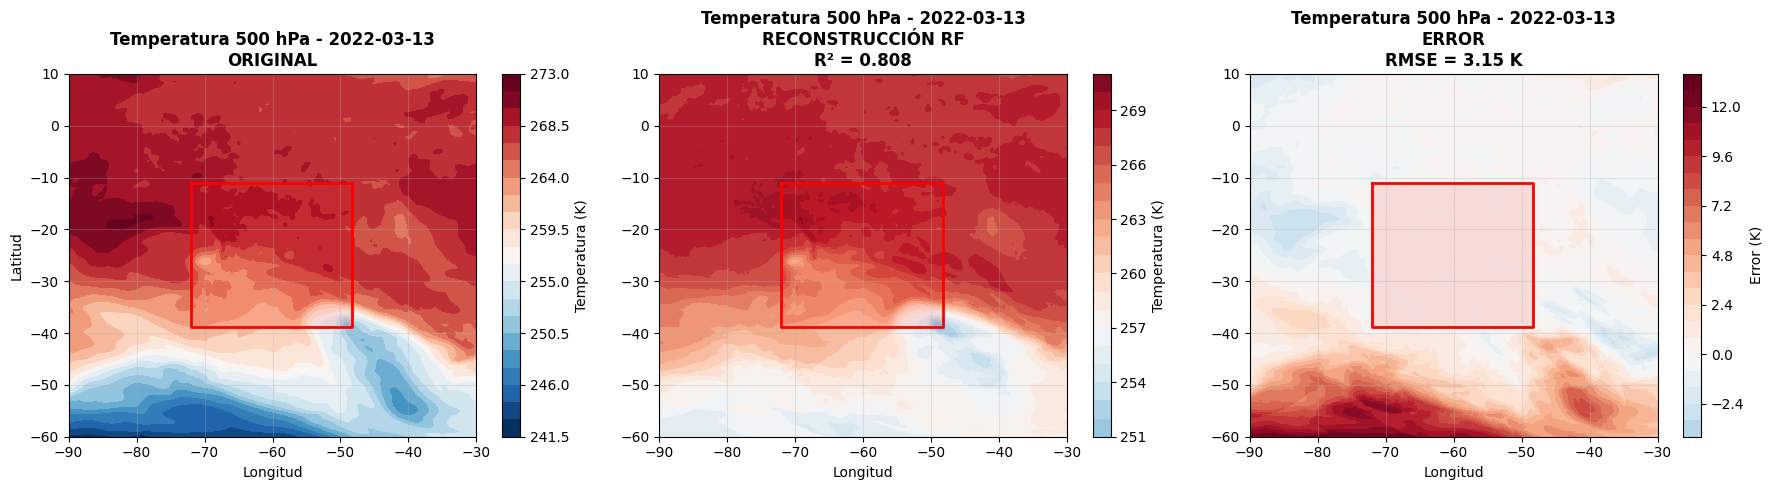

In [111]:
# ----------------------------------------------------------------------------
# CELDA 10: VISUALIZAR RESULTADOS
# ----------------------------------------------------------------------------
print("\n9. VISUALIZANDO RESULTADOS")
print("-"*40)

def visualizar_reconstruccion(true_grid, pred_grid, lat, lon, 
                             titulo="Temperatura 500 hPa - 2022-03-13"):
    """Visualiza comparación entre datos originales y reconstruidos."""
    
    # Determinar rangos para escalas consistentes
    vmin = min(np.nanmin(true_grid), np.nanmin(pred_grid))
    vmax = max(np.nanmax(true_grid), np.nanmax(pred_grid))
    
    # Crear figura
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. Datos originales
    im1 = axes[0].contourf(lon, lat, true_grid, levels=20, 
                          cmap='RdBu_r', vmin=vmin, vmax=vmax)
    axes[0].set_title(f"{titulo}\nORIGINAL", fontsize=12, fontweight='bold')
    axes[0].set_xlabel("Longitud", fontsize=10)
    axes[0].set_ylabel("Latitud", fontsize=10)
    axes[0].grid(True, alpha=0.3)
    plt.colorbar(im1, ax=axes[0], label='Temperatura (K)')
    
    # 2. Reconstrucción Random Forest
    im2 = axes[1].contourf(lon, lat, pred_grid, levels=20, 
                          cmap='RdBu_r', vmin=vmin, vmax=vmax)
    axes[1].set_title(f"{titulo}\nRECONSTRUCCIÓN RF\nR² = {r2_full:.3f}", 
                     fontsize=12, fontweight='bold')
    axes[1].set_xlabel("Longitud", fontsize=10)
    axes[1].grid(True, alpha=0.3)
    plt.colorbar(im2, ax=axes[1], label='Temperatura (K)')
    
    # 3. Error (Diferencia)
    error_grid = pred_grid - true_grid
    max_error = np.nanmax(np.abs(error_grid))
    
    im3 = axes[2].contourf(lon, lat, error_grid, levels=20, 
                          cmap='RdBu_r', vmin=-max_error, vmax=max_error)
    axes[2].set_title(f"{titulo}\nERROR\nRMSE = {rmse_full:.2f} K", 
                     fontsize=12, fontweight='bold')
    axes[2].set_xlabel("Longitud", fontsize=10)
    axes[2].grid(True, alpha=0.3)
    cbar3 = plt.colorbar(im3, ax=axes[2])
    cbar3.set_label('Error (K)')
    
    # Marcar subregión de entrenamiento
    for ax in axes:
        # Encontrar límites geográficos de la subregión
        idx_lat_min = np.where(lat_mask)[0][0]
        idx_lat_max = np.where(lat_mask)[0][-1]
        idx_lon_min = np.where(lon_mask)[0][0]
        idx_lon_max = np.where(lon_mask)[0][-1]
        
        # Coordenadas del rectángulo
        rect_lon = [lon[idx_lon_min], lon[idx_lon_max], lon[idx_lon_max], lon[idx_lon_min], lon[idx_lon_min]]
        rect_lat = [lat[idx_lat_min], lat[idx_lat_min], lat[idx_lat_max], lat[idx_lat_max], lat[idx_lat_min]]
        
        ax.plot(rect_lon, rect_lat, 'r-', linewidth=2)
        ax.fill(rect_lon, rect_lat, color='red', alpha=0.1)
    
    plt.tight_layout()
    
    # Guardar figura
    ruta_figura = os.path.join("rf_outputs", "reconstruccion_comparacion.png")
    plt.savefig(ruta_figura, dpi=300, bbox_inches='tight')
    print(f"✓ Figura guardada en: {ruta_figura}")
    
    plt.show()
    
    return fig, error_grid

# Generar visualización
fig, error_grid = visualizar_reconstruccion(
    y_true_grid, y_pred_grid, lat, lon,
    titulo="Temperatura 500 hPa - 2022-03-13"
)


10. ANÁLISIS DE ERROR
----------------------------------------
Estadísticas de error:
  Error absoluto medio: 1.678 K
  Error máximo absoluto: 12.813 K
  Desviación estándar del error: 2.902 K
✓ Análisis de error guardado en: rf_outputs\analisis_error.png


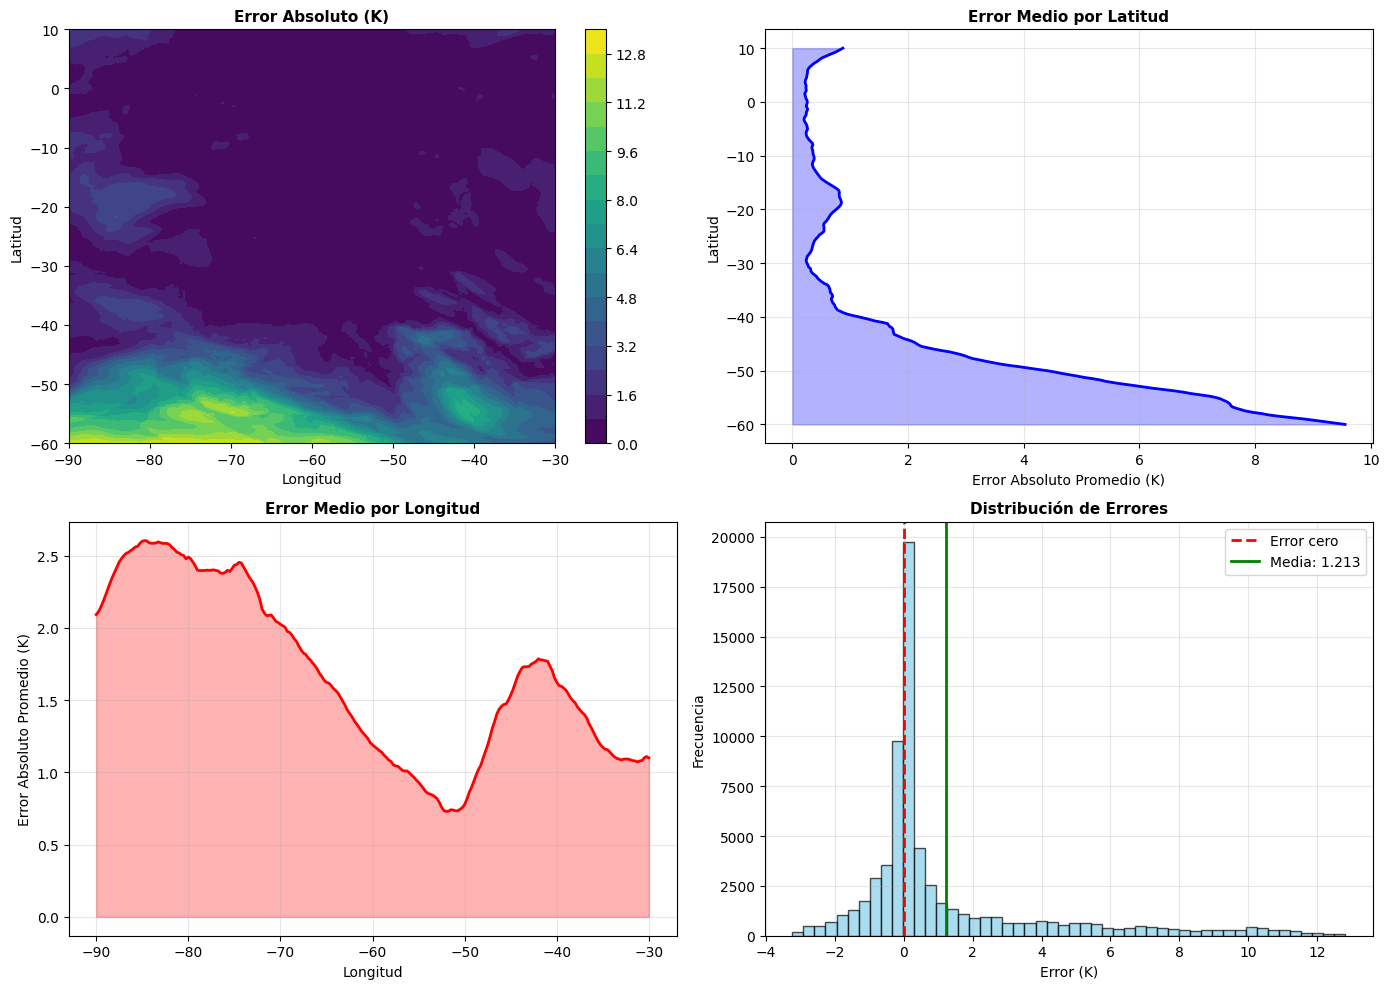

In [87]:
# ----------------------------------------------------------------------------
# CELDA 11: ANÁLISIS DE ERROR
# ----------------------------------------------------------------------------
print("\n10. ANÁLISIS DE ERROR")
print("-"*40)

def analizar_error(error_grid, lat, lon):
    """Analiza la distribución espacial del error."""
    
    error_absoluto = np.abs(error_grid)
    
    # Calcular estadísticas
    error_medio = np.nanmean(error_absoluto)
    error_max = np.nanmax(error_absoluto)
    error_std = np.nanstd(error_grid)  # Error con signo para ver sesgo
    
    print(f"Estadísticas de error:")
    print(f"  Error absoluto medio: {error_medio:.3f} K")
    print(f"  Error máximo absoluto: {error_max:.3f} K")
    print(f"  Desviación estándar del error: {error_std:.3f} K")
    
    # Error por latitud
    error_por_lat = np.nanmean(error_absoluto, axis=1)
    
    # Error por longitud
    error_por_lon = np.nanmean(error_absoluto, axis=0)
    
    # Crear figura de análisis
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Mapa de error absoluto
    im1 = axes[0, 0].contourf(lon, lat, error_absoluto, levels=20, cmap='viridis')
    axes[0, 0].set_title("Error Absoluto (K)", fontsize=11, fontweight='bold')
    axes[0, 0].set_xlabel("Longitud")
    axes[0, 0].set_ylabel("Latitud")
    plt.colorbar(im1, ax=axes[0, 0])
    
    # 2. Error por latitud
    axes[0, 1].plot(error_por_lat, lat, 'b-', linewidth=2)
    axes[0, 1].fill_betweenx(lat, 0, error_por_lat, alpha=0.3, color='blue')
    axes[0, 1].set_title("Error Medio por Latitud", fontsize=11, fontweight='bold')
    axes[0, 1].set_xlabel("Error Absoluto Promedio (K)")
    axes[0, 1].set_ylabel("Latitud")
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Error por longitud
    axes[1, 0].plot(lon, error_por_lon, 'r-', linewidth=2)
    axes[1, 0].fill_between(lon, 0, error_por_lon, alpha=0.3, color='red')
    axes[1, 0].set_title("Error Medio por Longitud", fontsize=11, fontweight='bold')
    axes[1, 0].set_xlabel("Longitud")
    axes[1, 0].set_ylabel("Error Absoluto Promedio (K)")
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Histograma de errores
    error_flat = error_grid.flatten()
    error_flat = error_flat[~np.isnan(error_flat)]
    
    axes[1, 1].hist(error_flat, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
    axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Error cero')
    axes[1, 1].axvline(x=np.mean(error_flat), color='green', linestyle='-', 
                      linewidth=2, label=f'Media: {np.mean(error_flat):.3f}')
    
    axes[1, 1].set_title("Distribución de Errores", fontsize=11, fontweight='bold')
    axes[1, 1].set_xlabel("Error (K)")
    axes[1, 1].set_ylabel("Frecuencia")
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Guardar
    ruta_analisis = os.path.join("rf_outputs", "analisis_error.png")
    plt.savefig(ruta_analisis, dpi=300, bbox_inches='tight')
    print(f"✓ Análisis de error guardado en: {ruta_analisis}")
    
    plt.show()
    
    return {
        'error_grid': error_grid,
        'error_absoluto': error_absoluto,
        'error_por_lat': error_por_lat,
        'error_por_lon': error_por_lon,
        'error_medio': error_medio,
        'error_max': error_max
    }

# Ejecutar análisis de error
resultados_error = analizar_error(error_grid, lat, lon)